In [42]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, f1_score, precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import time

import warnings
warnings.filterwarnings('ignore')

In [43]:
df = pd.read_csv('heart_cleaned.csv')

In [44]:
class FeatureCategorizer:
    def __init__(self, df):
        self.df = df.copy()
        self.continuous_features = []
        self.binary_features = []
        
    def categorize_features(self):
        """Automatically categorize features as continuous or binary"""
        print("Analyzing features...")
        print("="*50)
        
        for col in self.df.columns:
            unique_vals = self.df[col].nunique()
            is_numeric = pd.api.types.is_numeric_dtype(self.df[col])
            unique_values = sorted(self.df[col].unique())
            
            print(f"\n{col}:")
            print(f"  - Unique values: {unique_vals}")
            print(f"  - Is numeric: {is_numeric}")
            print(f"  - Sample values: {unique_values[:5] if len(unique_values) > 5 else unique_values}")
            
            if is_numeric:
                if unique_vals == 2 or set(self.df[col].unique()).issubset({0, 1, 0.0, 1.0}):
                    self.binary_features.append(col)
                    print(f"  → Classified as: BINARY")
                else:
                    self.continuous_features.append(col)
                    print(f"  → Classified as: CONTINUOUS")
            else:
                # Handle boolean or string binary features
                if unique_vals == 2:
                    self.binary_features.append(col)
                    print(f"  → Classified as: BINARY")
                else:
                    print(f"  → Classified as: OTHER (will be ignored)")
        
        print(f"\n{'='*50}")
        print("FINAL CATEGORIZATION:")
        print(f"{'='*50}")
        print(f"Continuous features ({len(self.continuous_features)}): {self.continuous_features}")
        print(f"Binary features ({len(self.binary_features)}): {self.binary_features}")
        
        return self.continuous_features, self.binary_features
    
    def get_feature_stats(self):
        """Get detailed statistics for each feature type"""
        print(f"\n{'='*50}")
        print("FEATURE STATISTICS:")
        print(f"{'='*50}")
        
        if self.continuous_features:
            print("\nCONTINUOUS FEATURES:")
            for feature in self.continuous_features:
                data = self.df[feature]
                print(f"\n{feature}:")
                print(f"  Mean: {data.mean():.2f}")
                print(f"  Std:  {data.std():.2f}")
                print(f"  Min:  {data.min():.2f}")
                print(f"  Max:  {data.max():.2f}")
                print(f"  Q1:   {data.quantile(0.25):.2f}")
                print(f"  Q3:   {data.quantile(0.75):.2f}")
        
        if self.binary_features:
            print("\nBINARY FEATURES:")
            for feature in self.binary_features:
                value_counts = self.df[feature].value_counts()
                print(f"\n{feature}:")
                for val, count in value_counts.items():
                    percentage = (count / len(self.df)) * 100
                    print(f"  {val}: {count} ({percentage:.1f}%)")

In [45]:
# Categorize features
categorizer = FeatureCategorizer(df)
continuous_features, binary_features = categorizer.categorize_features()

# Get detailed statistics
categorizer.get_feature_stats()

Analyzing features...

Age:
  - Unique values: 50
  - Is numeric: True
  - Sample values: [np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32)]
  → Classified as: CONTINUOUS

Sex:
  - Unique values: 2
  - Is numeric: True
  - Sample values: [np.int64(0), np.int64(1)]
  → Classified as: BINARY

RestingBP:
  - Unique values: 67
  - Is numeric: True
  - Sample values: [np.int64(0), np.int64(80), np.int64(92), np.int64(94), np.int64(95)]
  → Classified as: CONTINUOUS

Cholesterol:
  - Unique values: 222
  - Is numeric: True
  - Sample values: [np.float64(85.0), np.float64(100.0), np.float64(110.0), np.float64(113.0), np.float64(117.0)]
  → Classified as: CONTINUOUS

FastingBS:
  - Unique values: 2
  - Is numeric: True
  - Sample values: [np.int64(0), np.int64(1)]
  → Classified as: BINARY

MaxHR:
  - Unique values: 119
  - Is numeric: True
  - Sample values: [np.int64(60), np.int64(63), np.int64(67), np.int64(69), np.int64(70)]
  → Classified as: CONTINUOUS

ExerciseAngina

In [46]:
class ProgressiveOutlierGenerator:
    def __init__(self, df, continuous_features, pre_fitted_scaler=None, pre_fitted_pca=None):
        self.original_df = df.copy()
        self.current_df = df.copy()
        self.continuous_features = continuous_features
        self.contamination_history = []
        self.outlier_indices = set()
        
        # Note: PCA models are no longer needed for univariate-only generation
        # but we keep the parameters for backwards compatibility
        #self.scaler = pre_fitted_scaler
        #self.pca = pre_fitted_pca

        print(f"Initialized with:")
        print(f"  - Dataset size: {len(df)} samples")
        print(f"  - Continuous features: {len(continuous_features)}")
        print(f"  - Mode: Univariate outliers only")

    def add_continuous_outliers(self, contamination_rate=0.02, methods=['extreme'], seed=None):
        rng = np.random.default_rng(seed)
        if not self.continuous_features:
            return {}

        univariate_methods = [m for m in methods if m != 'multivariate']
        if not univariate_methods:
            univariate_methods = ['extreme']

        n_samples = len(self.current_df)
        n_new_outliers = int(round(n_samples * contamination_rate))

        # ensure at least 1 if contamination_rate>0 and there are samples
        if n_new_outliers == 0 and contamination_rate > 0 and n_samples > 0:
            n_new_outliers = 1

        # Use index *labels* (robusto con indici non numerici)
        available_labels = list(set(self.current_df.index) - set(self.outlier_indices))

        if len(available_labels) == 0:
            print("No more clean samples available for contamination.")
            return {}

        if len(available_labels) < n_new_outliers:
            n_new_outliers = len(available_labels)
            print(f"Warning: Only {len(available_labels)} clean samples remaining. Using all of them.")

        # choose labels (object dtype safe)
        chosen = rng.choice(available_labels, size=n_new_outliers, replace=False)

        contamination_info = {}

        # ensure we can revert to original values later
        if not hasattr(self, 'original_values'):
            self.original_values = {}

        for label in chosen:
            method = str(rng.choice(univariate_methods))
            feature = str(rng.choice(self.continuous_features))

            # save original value (first time)
            if label not in self.original_values:
                self.original_values[label] = {}
            if feature not in self.original_values[label]:
                self.original_values[label][feature] = self.current_df.at[label, feature]

            # clean_data: exclude already contaminated *labels*
            clean_labels = [lab for lab in self.current_df.index if lab not in self.outlier_indices]
            clean_data = self.current_df.loc[clean_labels, feature].dropna()
            if clean_data.empty:
                continue

            q1, q3 = clean_data.quantile(0.25), clean_data.quantile(0.75)
            iqr = q3 - q1
            std_val = float(clean_data.std()) if clean_data.std() != 0 else 1.0
            min_val, max_val = clean_data.min(), clean_data.max()

            orig_val = float(self.current_df.at[label, feature])

            if method == 'extreme':
                if rng.random() < 0.5:
                    outlier_val = q1 - rng.uniform(3, 6) * iqr
                    outlier_val = max(outlier_val, float(min_val) - 3 * std_val)
                else:
                    outlier_val = q3 + rng.uniform(3, 6) * iqr
                    outlier_val = min(outlier_val, float(max_val) + 3 * std_val)
            elif method == 'shift':
                shift_factor = rng.choice([-1, 1]) * rng.uniform(2, 4)
                outlier_val = orig_val + shift_factor * std_val
            elif method == 'noise':
                noise_factor = rng.choice([-1, 1]) * rng.uniform(3, 5)
                outlier_val = orig_val + noise_factor * std_val
            else:
                # fallback
                outlier_val = q3 + rng.uniform(3, 6) * iqr

            # domain-aware clipping instead of blind abs
            if feature in ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']:
                lower_bound = 0
                outlier_val = max(outlier_val, lower_bound)

            # preserve integer dtype if necessary
            if pd.api.types.is_integer_dtype(self.current_df[feature].dtype):
                outlier_val = int(round(outlier_val))

            self.current_df.at[label, feature] = outlier_val

            contamination_info.setdefault(feature, []).append({
                'index': label,
                'original_value': self.original_values[label][feature],
                'outlier_value': outlier_val,
                'method': method
            })

        # store labels of contaminated rows
        self.outlier_indices.update(set(chosen))

        return contamination_info


    def progressive_contamination(self, steps=10, max_contamination=1, continuous_methods=['extreme', 'shift']):
        """Progressively contaminate the dataset in steps with univariate outliers only."""
        # Filter out multivariate methods
        univariate_methods = [m for m in continuous_methods if m != 'multivariate']
        if not univariate_methods:
            print("No valid univariate methods provided. Using default methods.")
            univariate_methods = ['extreme', 'shift']
        
        contamination_rates = np.linspace(0, max_contamination, steps + 1)[1:]
        datasets = [self.original_df.copy()]
        
        print("Starting progressive contamination (univariate only)...")
        print(f"Steps: {steps}")
        print(f"Methods: {univariate_methods}")
        print(f"Contamination rates: {[f'{rate:.3f}' for rate in contamination_rates]}")
        
        for step, target_rate in enumerate(contamination_rates, 1):
            print(f"\n--- Step {step}/{steps}: Target contamination {target_rate:.3f} ---")
            
            current_contamination_rate = len(self.outlier_indices) / len(self.current_df)
            incremental_rate = target_rate - current_contamination_rate
            
            if incremental_rate <= 0:
                print("Target contamination already reached or exceeded.")
                datasets.append(self.current_df.copy())
                continue
            
            print(f"Adding univariate outliers (rate: {incremental_rate:.3f})...")
            cont_info = self.add_continuous_outliers(
                contamination_rate=incremental_rate,
                methods=univariate_methods
            )
            
            actual_contamination = len(self.outlier_indices) / len(self.current_df)
            print(f"Actual total contamination: {actual_contamination:.3f}")
            print(f"Total contaminated samples: {len(self.outlier_indices)}")
            
            self.contamination_history.append({
                'step': step,
                'target_rate': target_rate,
                'actual_rate': actual_contamination,
                'contaminated_samples': len(self.outlier_indices),
                'continuous_info': cont_info,
            })
            
            datasets.append(self.current_df.copy())
        
        return datasets, self.contamination_history

    def get_contamination_summary(self):
        """Print a detailed summary of contamination."""
        print(f"\n{'='*60}")
        print("CONTAMINATION SUMMARY (UNIVARIATE ONLY)")
        print(f"{'='*60}")
        
        print(f"Original dataset size: {len(self.original_df)} samples")
        print(f"Total contaminated samples: {len(self.outlier_indices)}")
        
        for i, history in enumerate(self.contamination_history, 1):
            print(f"\nStep {i}:")
            print(f"  Target rate: {history['target_rate']:.3f}")
            print(f"  Actual rate: {history['actual_rate']:.3f}")
            print(f"  Contaminated samples: {history['contaminated_samples']}")
            
            if history['continuous_info']:
                print("  Univariate outliers by feature:")
                for feature, outliers in history['continuous_info'].items():
                    if outliers:
                        method_counts = {}
                        for outlier in outliers:
                            method = outlier['method']
                            method_counts[method] = method_counts.get(method, 0) + 1
                        
                        method_str = ", ".join([f"{method}: {count}" for method, count in method_counts.items()])
                        print(f"    {feature}: {len(outliers)} new outliers ({method_str})")

    def reset_to_clean(self):
        """Reset to original clean dataset."""
        self.current_df = self.original_df.copy()
        self.outlier_indices = set()
        self.contamination_history = []
        print("Dataset reset to original clean state.")
    
    def get_datasets(self):
        """Return both clean and current contaminated dataset."""
        return self.original_df.copy(), self.current_df.copy()
    
    def debug_outlier_counts(self):
        """Debug function to check outlier counts per feature and method"""
        print("\n" + "="*60)
        print("OUTLIER DEBUG INFORMATION (UNIVARIATE ONLY)")
        print("="*60)
        
        for feature in self.continuous_features:
            method_counts = {}
            
            for history in self.contamination_history:
                if feature in history['continuous_info']:
                    for outlier_info in history['continuous_info'][feature]:
                        method = outlier_info['method']
                        method_counts[method] = method_counts.get(method, 0) + 1
            
            print(f"{feature}:")
            if method_counts:
                for method, count in method_counts.items():
                    print(f"  - {method} outliers: {count}")
                print(f"  - Total outliers: {sum(method_counts.values())}")
            else:
                print(f"  - No outliers")
            print()

In [47]:
loaded_scaler = joblib.load('scaler.joblib')
loaded_pca = joblib.load('pca.joblib')

# Initialize the outlier generator with categorized features
generator = ProgressiveOutlierGenerator(df, continuous_features, pre_fitted_scaler=loaded_scaler, 
    pre_fitted_pca=loaded_pca)

# Generate progressive outliers
datasets, contamination_history = generator.progressive_contamination(
    steps=10,                          
    max_contamination=1,           
    continuous_methods=['extreme', 'shift', 'noise']  
)

# Print detailed summary
generator.get_contamination_summary()

Initialized with:
  - Dataset size: 918 samples
  - Continuous features: 5
  - Mode: Univariate outliers only
Starting progressive contamination (univariate only)...
Steps: 10
Methods: ['extreme', 'shift', 'noise']
Contamination rates: ['0.100', '0.200', '0.300', '0.400', '0.500', '0.600', '0.700', '0.800', '0.900', '1.000']

--- Step 1/10: Target contamination 0.100 ---
Adding univariate outliers (rate: 0.100)...
Actual total contamination: 0.100
Total contaminated samples: 92

--- Step 2/10: Target contamination 0.200 ---
Adding univariate outliers (rate: 0.100)...
Actual total contamination: 0.200
Total contaminated samples: 184

--- Step 3/10: Target contamination 0.300 ---
Adding univariate outliers (rate: 0.100)...
Actual total contamination: 0.300
Total contaminated samples: 275

--- Step 4/10: Target contamination 0.400 ---
Adding univariate outliers (rate: 0.100)...
Actual total contamination: 0.400
Total contaminated samples: 367

--- Step 5/10: Target contamination 0.500 ---

Generating visualizations with only univariate outliers...


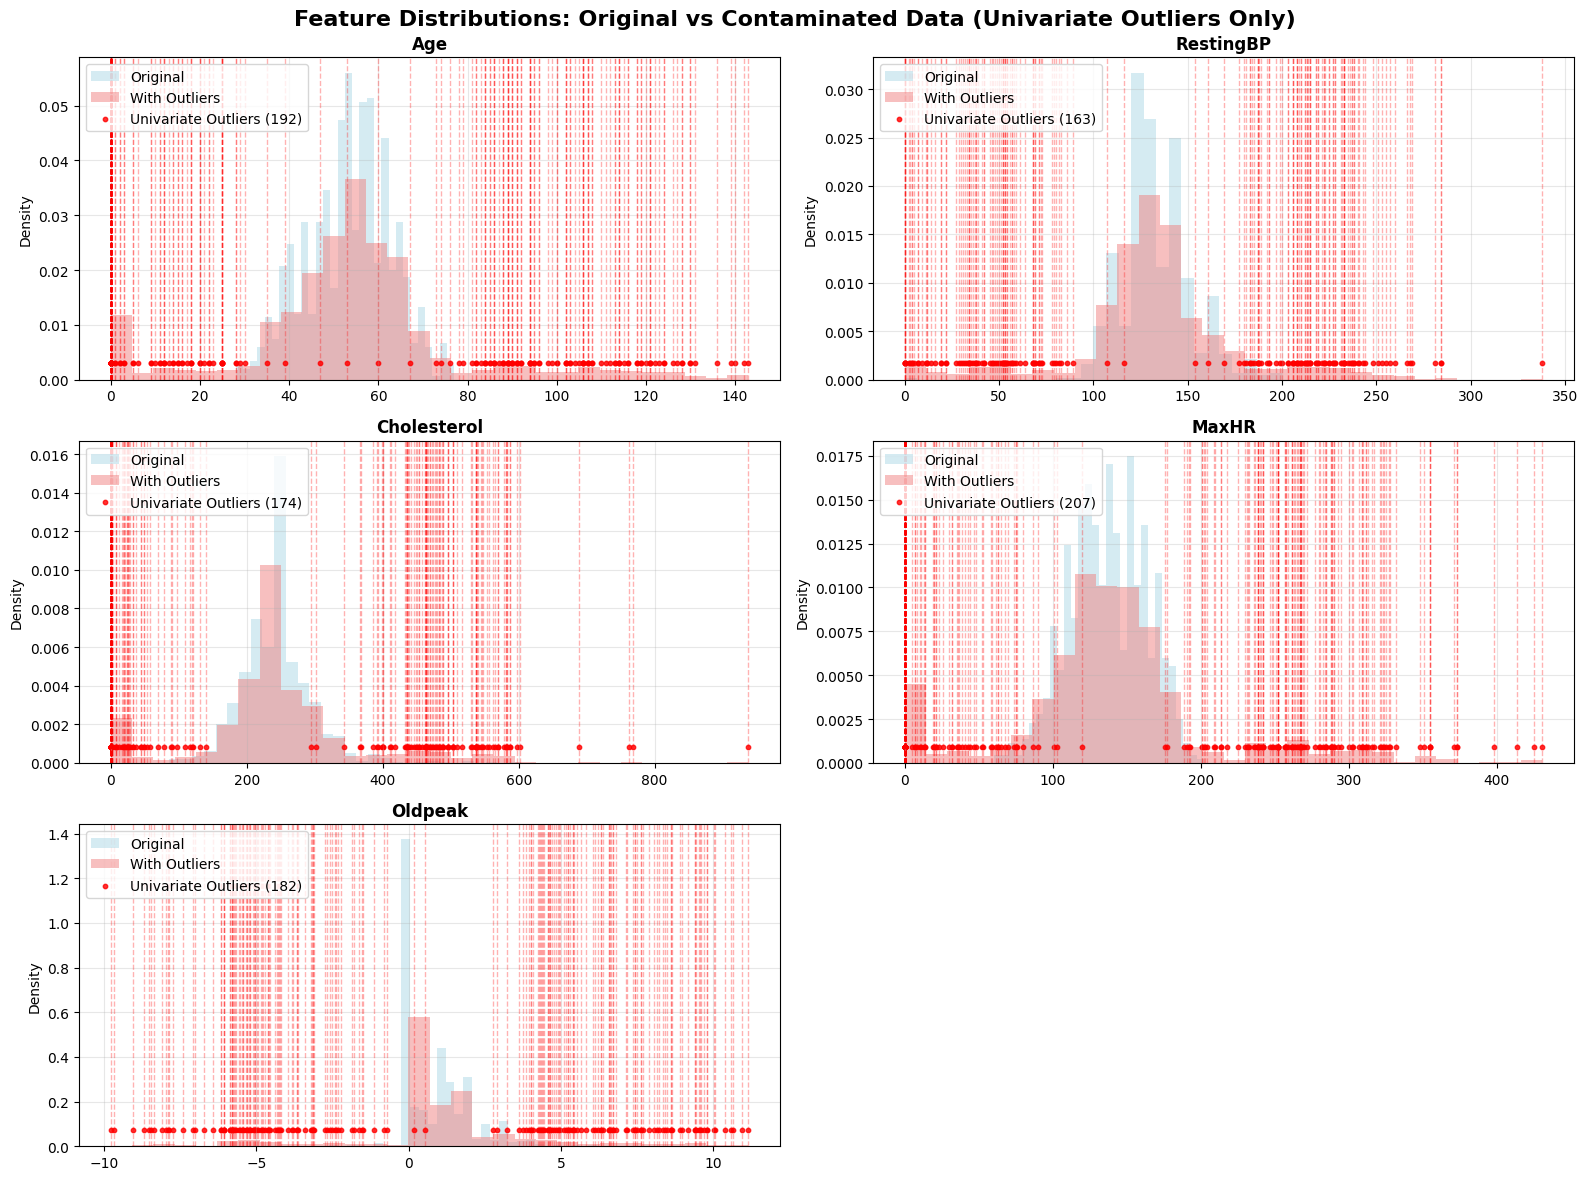

In [48]:
def plot_feature_distributions_with_univariate_outliers(generator, figsize=(16, 12)):
    """
    Plot distributions showing original data vs contaminated data with only univariate outliers highlighted.
    """
    n_features = len(generator.continuous_features)
    
    if n_features == 0:
        print("No features to visualize")
        return
    
    # Calculate grid size
    n_cols = 2
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # Handle single row case
    if n_rows == 1:
        if n_cols == 1:
            axes = [axes]
        else:
            axes = axes.reshape(1, -1)
    
    # Flatten axes array for easier indexing
    axes_flat = axes.flatten() if n_features > 1 else [axes]
    
    for i, feature in enumerate(generator.continuous_features):
        ax = axes_flat[i]
        
        # Get original and contaminated data
        original_data = generator.original_df[feature]
        contaminated_data = generator.current_df[feature]
        
        # Plot histograms
        ax.hist(original_data, alpha=0.5, label='Original', bins=30, 
                color='lightblue', density=True)
        ax.hist(contaminated_data, alpha=0.5, label='With Outliers', bins=30, 
                color='lightcoral', density=True)
        
        # --- ONLY UNIVARIATE OUTLIERS ---
        univariate_outliers = []
        for history in generator.contamination_history:
            if feature in history['continuous_info']:
                for outlier_info in history['continuous_info'][feature]:
                    if outlier_info['method'] != 'multivariate':
                        univariate_outliers.append(outlier_info['outlier_value'])
        
        # Plot univariate outliers
        if univariate_outliers:
            y_pos = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.05
            ax.scatter(univariate_outliers, [y_pos] * len(univariate_outliers), 
                       color='red', s=10, alpha=0.8, marker='o', 
                       label=f'Univariate Outliers ({len(univariate_outliers)})')
            for val in univariate_outliers:
                ax.axvline(x=val, color='red', linestyle='--', alpha=0.3, linewidth=1)
        
        ax.set_ylabel('Density')
        ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=10, loc='upper left')
        ax.grid(True, alpha=0.3)
    
    # Remove empty subplots
    for j in range(n_features, len(axes_flat)):
        fig.delaxes(axes_flat[j])
    
    plt.suptitle('Feature Distributions: Original vs Contaminated Data (Univariate Outliers Only)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Usage
print("Generating visualizations with only univariate outliers...")
plot_feature_distributions_with_univariate_outliers(generator)

In [49]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, f1_score, precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import time

In [50]:
all_metrics_outliers = []

def calculate_metrics(y_test, y_pred, model_name, approach, step_idx):
    """
    Calculate metrics and return a dictionary with model info
    """
    metrics = {
        'model': model_name,
        'approach': approach,
        'step': step_idx,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }
    
    # Print metrics (to maintain your current output format)
    print(f"Misure di performance globali {model_name.lower()} {approach.lower()}\n")
    print('Accuracy:', metrics['accuracy'])
    print('Precision:', metrics['precision'])
    print('Recall:', metrics['recall'])
    print('F1-score:', metrics['f1_score'])
    
    return metrics

timing_collector_outliers = {
    'dt_naive_training': 0,
    'dt_optimal_training': 0, 
    'dt_hyperparameter': 0,
    'svm_naive_training': 0,
    'svm_optimal_training': 0,
    'svm_hyperparameter': 0,
    'nn_naive_training': 0,
    'nn_optimal_training': 0,
    'nn_hyperparameter': 0
}



DECISION TREE - NAIVE


===== Training Decision Tree (Naive) at Step 0 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Step 0 | Training time (Naive): 0.0028 sec
Step 0 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.7391304347826086
Precision: 0.8105263157894737
Recall: 0.719626168224299
F1-score: 0.7623762376237624


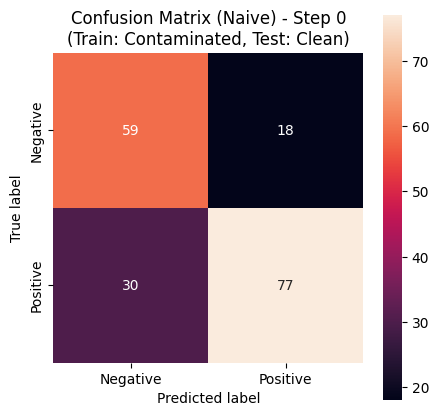


===== Training Decision Tree (Naive) at Step 1 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 1 | Training time (Naive): 0.0027 sec
Step 1 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.782608695652174
Precision: 0.8526315789473684
Recall: 0.7570093457943925
F1-score: 0.801980198019802


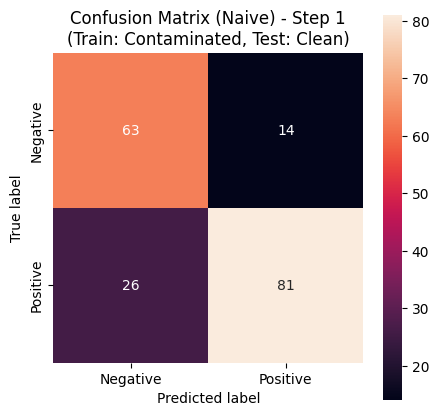


===== Training Decision Tree (Naive) at Step 2 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 2 | Training time (Naive): 0.0027 sec
Step 2 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.7554347826086957
Precision: 0.8229166666666666
Recall: 0.7383177570093458
F1-score: 0.7783251231527094


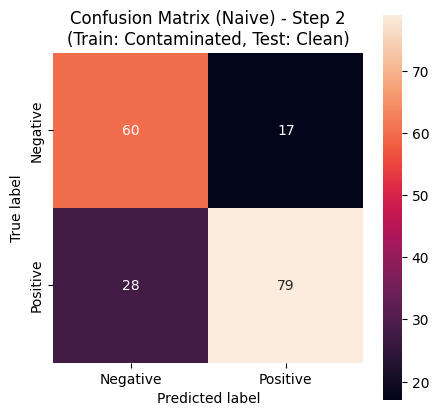


===== Training Decision Tree (Naive) at Step 3 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 3 | Training time (Naive): 0.0052 sec
Step 3 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.7934782608695652
Precision: 0.8791208791208791
Recall: 0.7476635514018691
F1-score: 0.8080808080808081


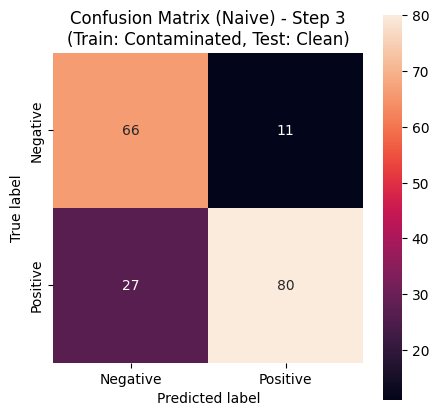


===== Training Decision Tree (Naive) at Step 4 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 4 | Training time (Naive): 0.0030 sec
Step 4 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.7989130434782609
Precision: 0.8571428571428571
Recall: 0.7850467289719626
F1-score: 0.8195121951219512


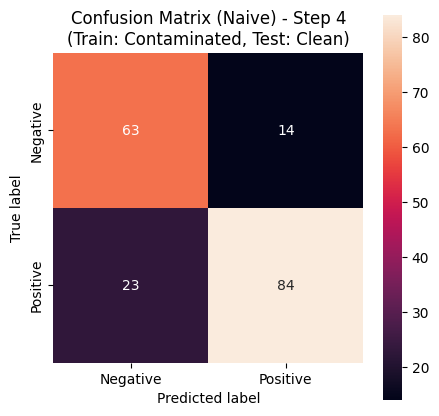


===== Training Decision Tree (Naive) at Step 5 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 5 | Training time (Naive): 0.0033 sec
Step 5 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.8260869565217391
Precision: 0.8504672897196262
Recall: 0.8504672897196262
F1-score: 0.8504672897196262


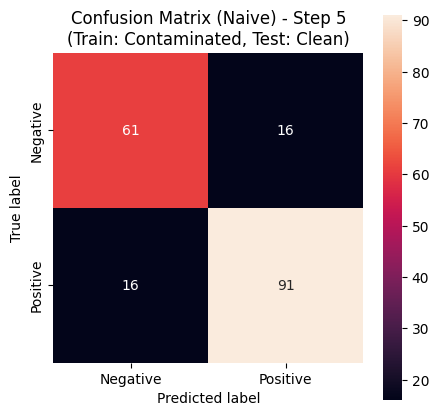


===== Training Decision Tree (Naive) at Step 6 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 6 | Training time (Naive): 0.0037 sec
Step 6 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.8478260869565217
Precision: 0.8558558558558559
Recall: 0.8878504672897196
F1-score: 0.8715596330275229


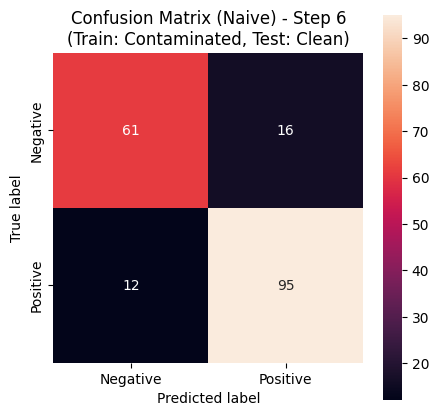


===== Training Decision Tree (Naive) at Step 7 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 7 | Training time (Naive): 0.0084 sec
Step 7 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.8315217391304348
Precision: 0.8454545454545455
Recall: 0.8691588785046729
F1-score: 0.8571428571428571


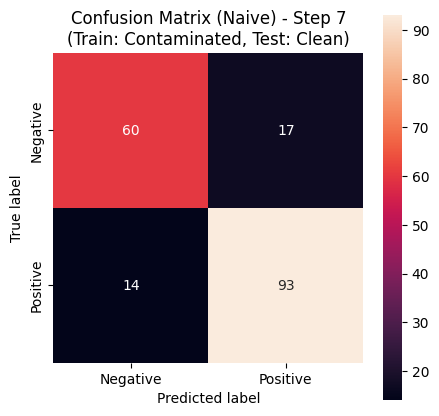


===== Training Decision Tree (Naive) at Step 8 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 8 | Training time (Naive): 0.0029 sec
Step 8 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.842391304347826
Precision: 0.8679245283018868
Recall: 0.8598130841121495
F1-score: 0.863849765258216


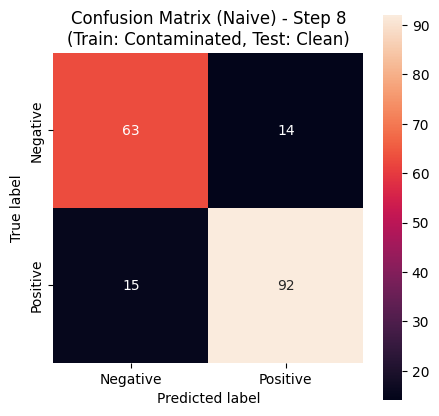


===== Training Decision Tree (Naive) at Step 9 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 9 | Training time (Naive): 0.0028 sec
Step 9 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.8586956521739131
Precision: 0.8715596330275229
Recall: 0.8878504672897196
F1-score: 0.8796296296296297


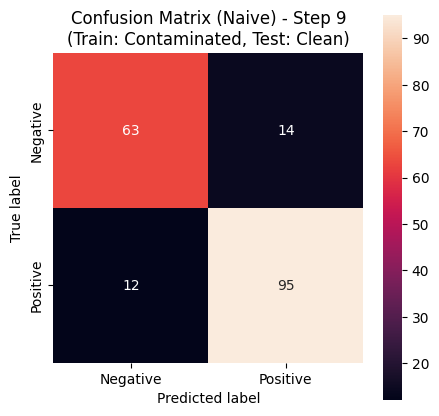


===== Training Decision Tree (Naive) at Step 10 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 10 | Training time (Naive): 0.0030 sec
Step 10 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.8206521739130435
Precision: 0.8303571428571429
Recall: 0.8691588785046729
F1-score: 0.8493150684931506


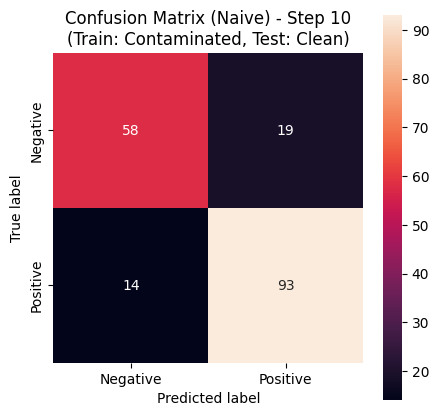



DECISION TREE - OPTIMIZED


===== Training Decision Tree (Optimized) at Step 0 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Step 0 | Training time (Optimized): 0.0023 sec
Step 0 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


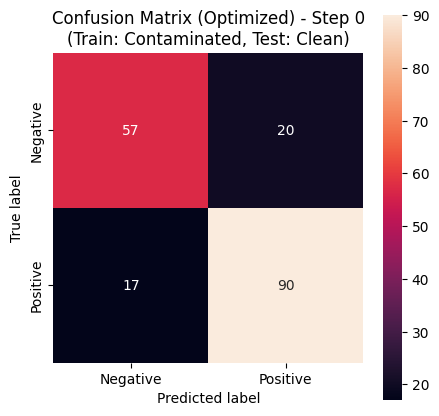


===== Training Decision Tree (Optimized) at Step 1 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 1 | Training time (Optimized): 0.0020 sec
Step 1 | Training Accuracy (Optimized): 0.8665
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


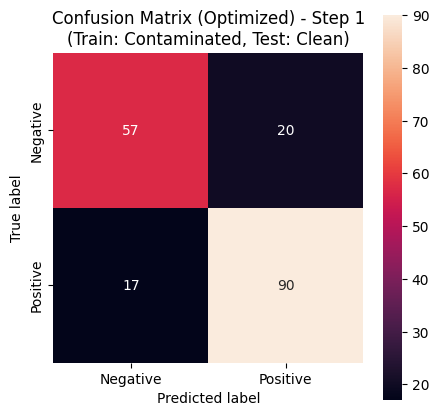


===== Training Decision Tree (Optimized) at Step 2 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 2 | Training time (Optimized): 0.0011 sec
Step 2 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


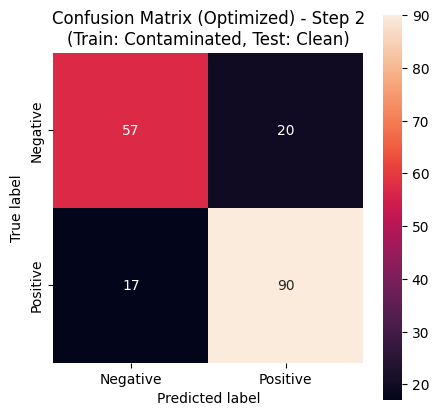


===== Training Decision Tree (Optimized) at Step 3 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 3 | Training time (Optimized): 0.0014 sec
Step 3 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


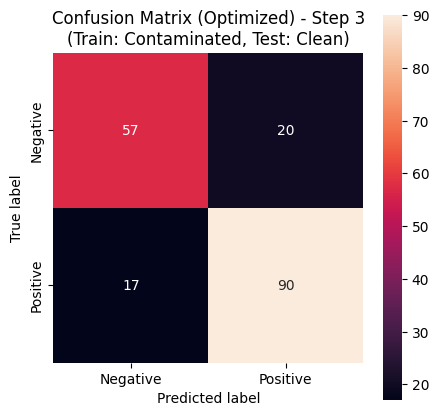


===== Training Decision Tree (Optimized) at Step 4 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 4 | Training time (Optimized): 0.0009 sec
Step 4 | Training Accuracy (Optimized): 0.8665
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


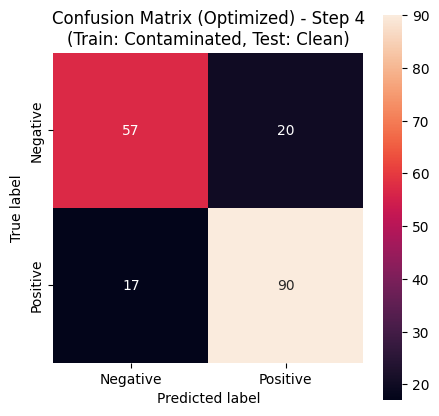


===== Training Decision Tree (Optimized) at Step 5 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 5 | Training time (Optimized): 0.0012 sec
Step 5 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


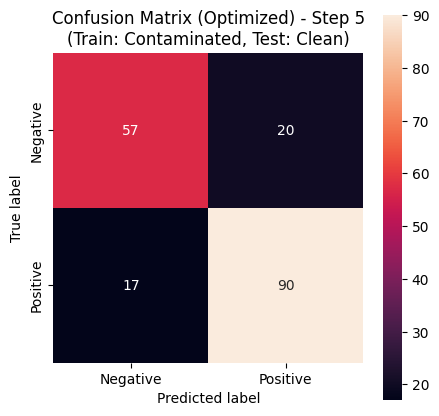


===== Training Decision Tree (Optimized) at Step 6 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 6 | Training time (Optimized): 0.0009 sec
Step 6 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


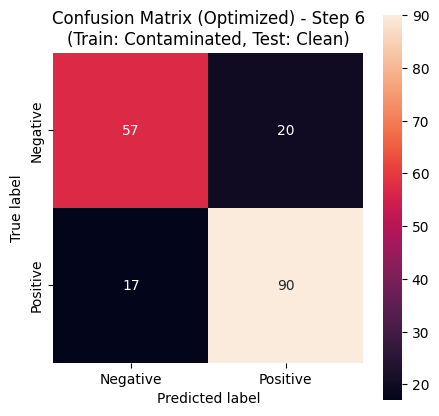


===== Training Decision Tree (Optimized) at Step 7 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 7 | Training time (Optimized): 0.0010 sec
Step 7 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


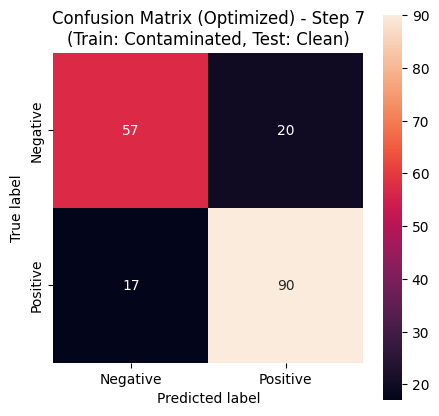


===== Training Decision Tree (Optimized) at Step 8 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 8 | Training time (Optimized): 0.0010 sec
Step 8 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


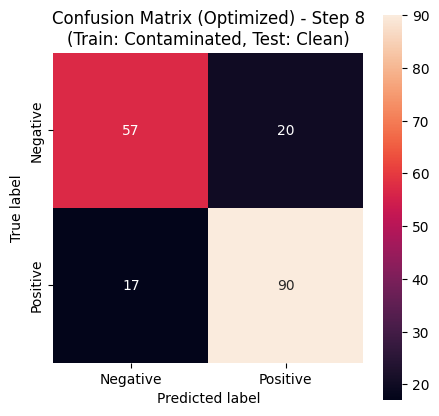


===== Training Decision Tree (Optimized) at Step 9 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 9 | Training time (Optimized): 0.0010 sec
Step 9 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


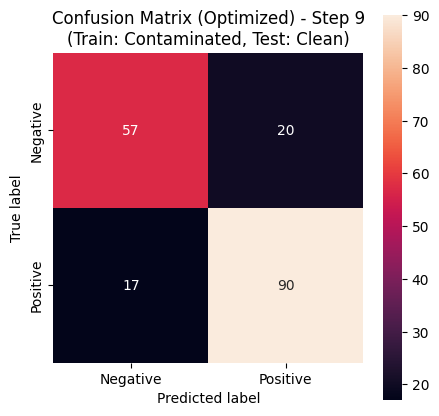


===== Training Decision Tree (Optimized) at Step 10 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 10 | Training time (Optimized): 0.0011 sec
Step 10 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


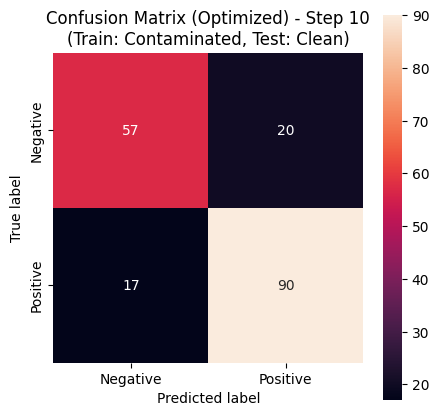



SVM - NAIVE


===== Training SVM (Naive) at Step 0 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Step 0 | Training time (Naive): 0.0080 sec
Step 0 | Training Accuracy (Naive): 0.7044
Misure di performance globali svm naive

Accuracy: 0.6739130434782609
Precision: 0.7238095238095238
Recall: 0.7102803738317757
F1-score: 0.7169811320754716


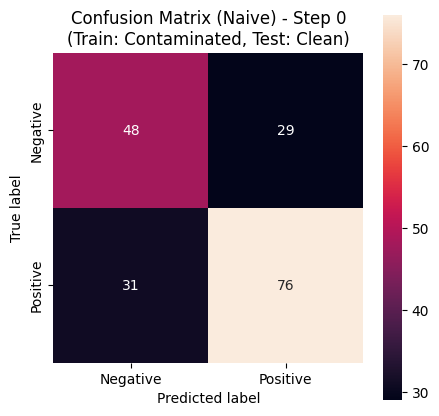


===== Training SVM (Naive) at Step 1 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 1 | Training time (Naive): 0.0081 sec
Step 1 | Training Accuracy (Naive): 0.7071
Misure di performance globali svm naive

Accuracy: 0.6793478260869565
Precision: 0.7142857142857143
Recall: 0.7476635514018691
F1-score: 0.730593607305936


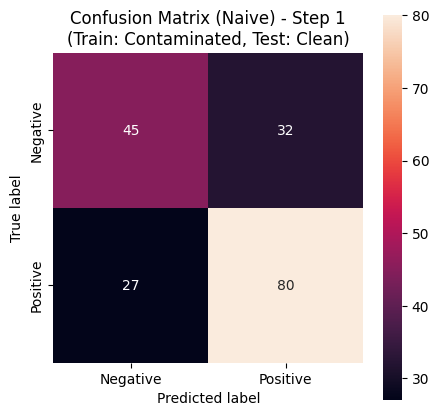


===== Training SVM (Naive) at Step 2 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 2 | Training time (Naive): 0.0088 sec
Step 2 | Training Accuracy (Naive): 0.7016
Misure di performance globali svm naive

Accuracy: 0.6793478260869565
Precision: 0.7068965517241379
Recall: 0.7663551401869159
F1-score: 0.7354260089686099


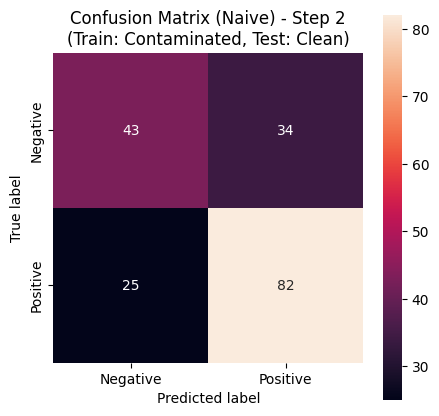


===== Training SVM (Naive) at Step 3 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 3 | Training time (Naive): 0.0084 sec
Step 3 | Training Accuracy (Naive): 0.6853
Misure di performance globali svm naive

Accuracy: 0.6902173913043478
Precision: 0.7016129032258065
Recall: 0.8130841121495327
F1-score: 0.7532467532467533


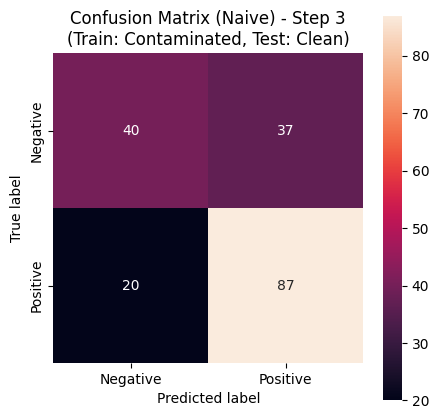


===== Training SVM (Naive) at Step 4 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 4 | Training time (Naive): 0.0093 sec
Step 4 | Training Accuracy (Naive): 0.6730
Misure di performance globali svm naive

Accuracy: 0.6956521739130435
Precision: 0.7007874015748031
Recall: 0.8317757009345794
F1-score: 0.7606837606837606


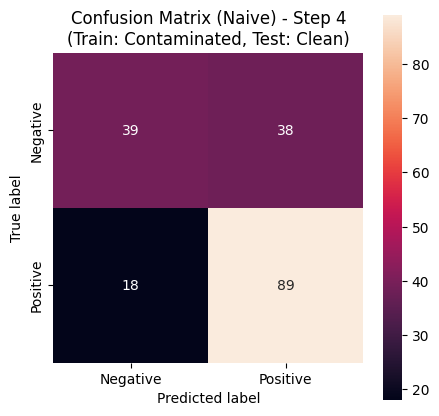


===== Training SVM (Naive) at Step 5 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 5 | Training time (Naive): 0.0105 sec
Step 5 | Training Accuracy (Naive): 0.6594
Misure di performance globali svm naive

Accuracy: 0.7119565217391305
Precision: 0.7109375
Recall: 0.8504672897196262
F1-score: 0.774468085106383


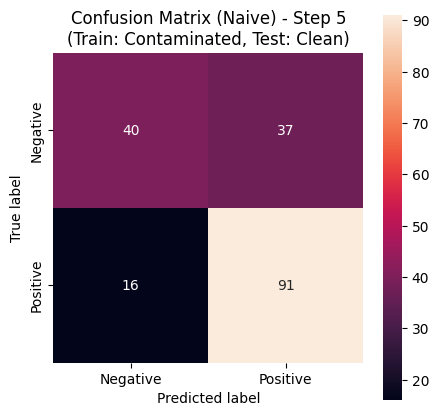


===== Training SVM (Naive) at Step 6 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 6 | Training time (Naive): 0.0100 sec
Step 6 | Training Accuracy (Naive): 0.6567
Misure di performance globali svm naive

Accuracy: 0.6793478260869565
Precision: 0.7033898305084746
Recall: 0.7757009345794392
F1-score: 0.7377777777777778


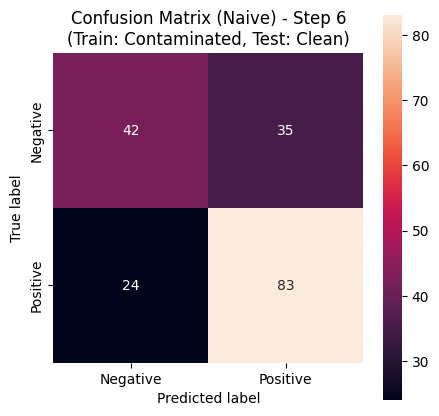


===== Training SVM (Naive) at Step 7 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 7 | Training time (Naive): 0.0082 sec
Step 7 | Training Accuracy (Naive): 0.6431
Misure di performance globali svm naive

Accuracy: 0.6956521739130435
Precision: 0.7107438016528925
Recall: 0.8037383177570093
F1-score: 0.7543859649122807


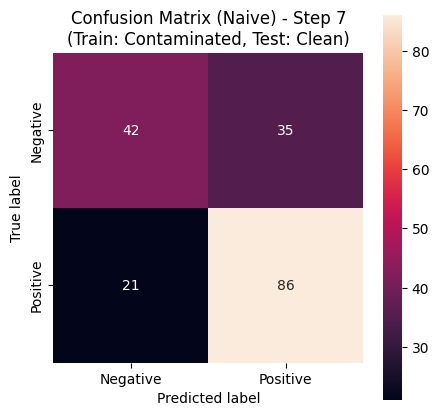


===== Training SVM (Naive) at Step 8 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 8 | Training time (Naive): 0.0084 sec
Step 8 | Training Accuracy (Naive): 0.6390
Misure di performance globali svm naive

Accuracy: 0.6793478260869565
Precision: 0.7142857142857143
Recall: 0.7476635514018691
F1-score: 0.730593607305936


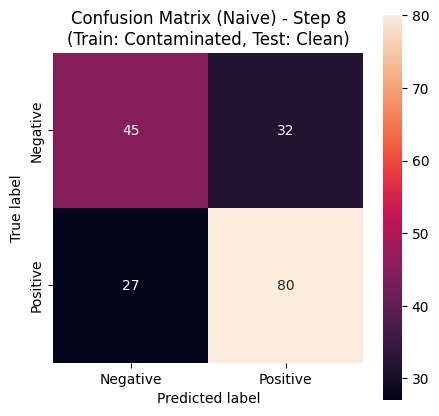


===== Training SVM (Naive) at Step 9 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 9 | Training time (Naive): 0.0083 sec
Step 9 | Training Accuracy (Naive): 0.6226
Misure di performance globali svm naive

Accuracy: 0.7119565217391305
Precision: 0.717741935483871
Recall: 0.8317757009345794
F1-score: 0.7705627705627706


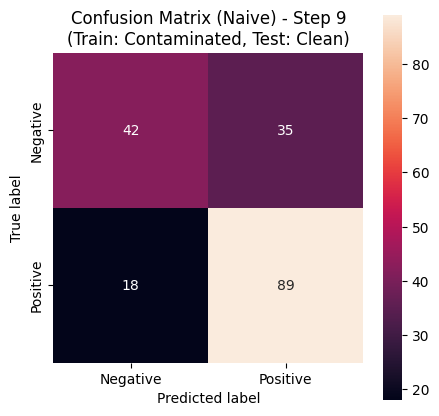


===== Training SVM (Naive) at Step 10 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 10 | Training time (Naive): 0.0093 sec
Step 10 | Training Accuracy (Naive): 0.6226
Misure di performance globali svm naive

Accuracy: 0.6902173913043478
Precision: 0.6811594202898551
Recall: 0.8785046728971962
F1-score: 0.7673469387755102


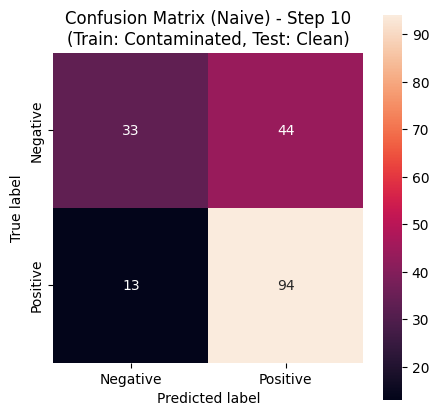



SVM - OPTIMIZED


===== Training SVM (Optimized) at Step 0 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Step 0 | Training time (Optimized): 0.0125 sec
Step 0 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.6141304347826086
Precision: 0.652542372881356
Recall: 0.719626168224299
F1-score: 0.6844444444444444


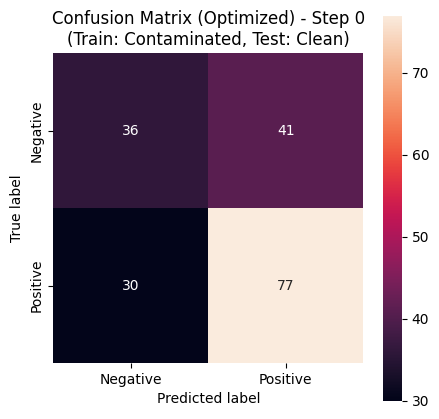


===== Training SVM (Optimized) at Step 1 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 1 | Training time (Optimized): 0.0124 sec
Step 1 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.625
Precision: 0.6637931034482759
Recall: 0.719626168224299
F1-score: 0.6905829596412556


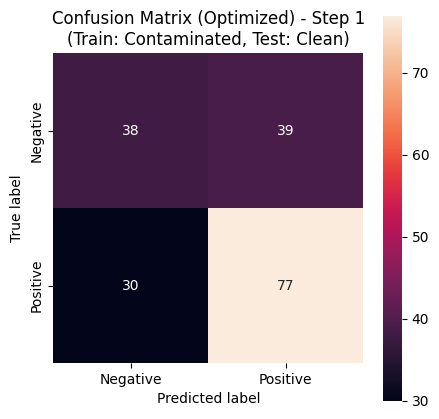


===== Training SVM (Optimized) at Step 2 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 2 | Training time (Optimized): 0.0133 sec
Step 2 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.6032608695652174
Precision: 0.6440677966101694
Recall: 0.7102803738317757
F1-score: 0.6755555555555556


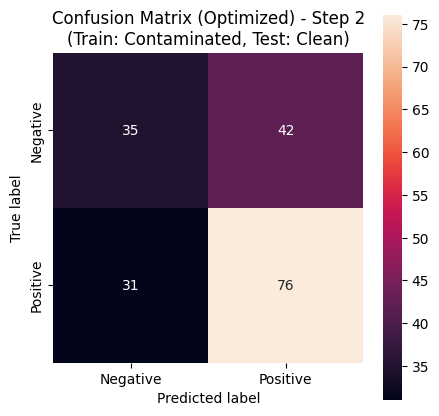


===== Training SVM (Optimized) at Step 3 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 3 | Training time (Optimized): 0.0134 sec
Step 3 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.6032608695652174
Precision: 0.6440677966101694
Recall: 0.7102803738317757
F1-score: 0.6755555555555556


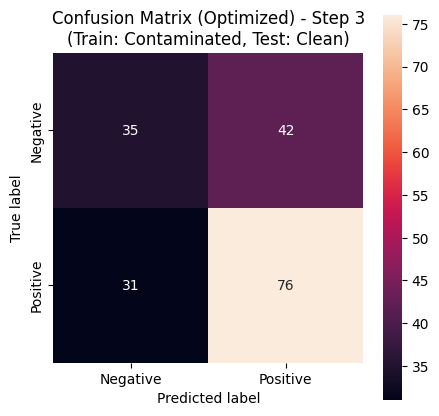


===== Training SVM (Optimized) at Step 4 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 4 | Training time (Optimized): 0.0144 sec
Step 4 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.6086956521739131
Precision: 0.6470588235294118
Recall: 0.719626168224299
F1-score: 0.6814159292035398


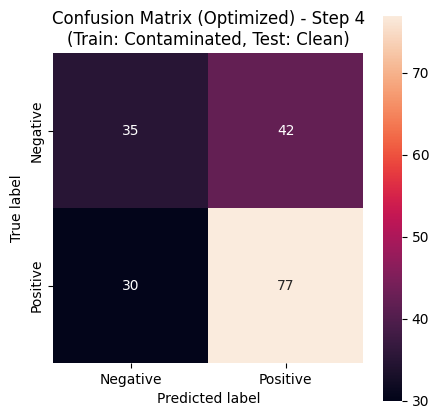


===== Training SVM (Optimized) at Step 5 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 5 | Training time (Optimized): 0.0125 sec
Step 5 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.5869565217391305
Precision: 0.6302521008403361
Recall: 0.7009345794392523
F1-score: 0.6637168141592921


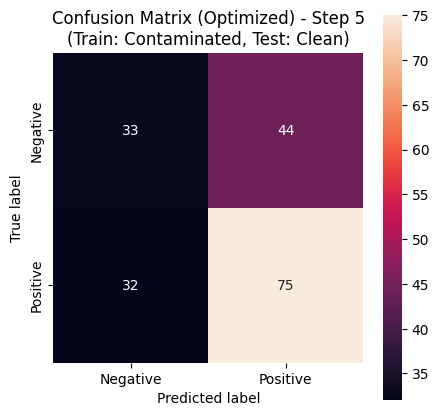


===== Training SVM (Optimized) at Step 6 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 6 | Training time (Optimized): 0.0134 sec
Step 6 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.5652173913043478
Precision: 0.6134453781512605
Recall: 0.6822429906542056
F1-score: 0.6460176991150443


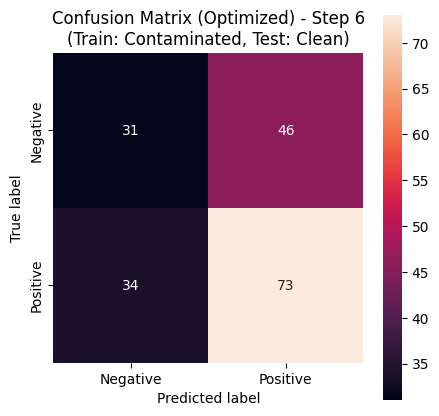


===== Training SVM (Optimized) at Step 7 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 7 | Training time (Optimized): 0.0129 sec
Step 7 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.5652173913043478
Precision: 0.6134453781512605
Recall: 0.6822429906542056
F1-score: 0.6460176991150443


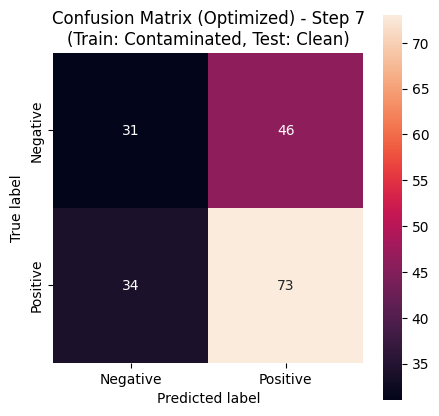


===== Training SVM (Optimized) at Step 8 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 8 | Training time (Optimized): 0.0127 sec
Step 8 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.5543478260869565
Precision: 0.6016260162601627
Recall: 0.6915887850467289
F1-score: 0.6434782608695652


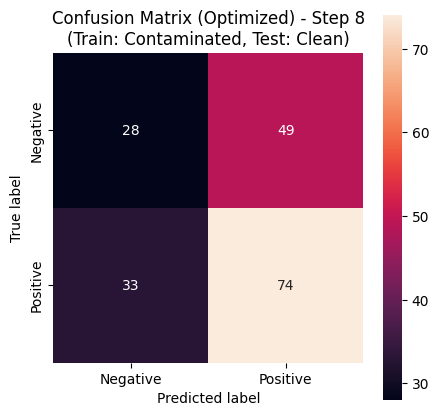


===== Training SVM (Optimized) at Step 9 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 9 | Training time (Optimized): 0.0127 sec
Step 9 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.5815217391304348
Precision: 0.6102941176470589
Recall: 0.7757009345794392
F1-score: 0.6831275720164609


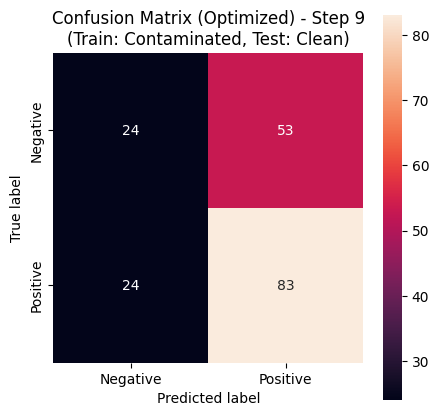


===== Training SVM (Optimized) at Step 10 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 10 | Training time (Optimized): 0.0130 sec
Step 10 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.592391304347826
Precision: 0.6176470588235294
Recall: 0.7850467289719626
F1-score: 0.691358024691358


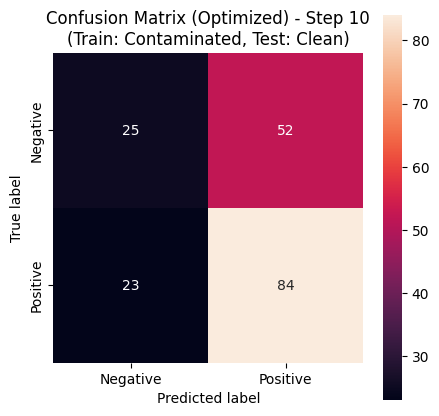



NEURAL NETWORK - NAIVE


===== Training Neural Network (Naive) at Step 0 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Step 0 | Training time (Naive): 0.1067 sec
Step 0 | Training Accuracy (Naive): 0.8747
Misure di performance globali neural network naive

Accuracy: 0.842391304347826
Precision: 0.8362068965517241
Recall: 0.9065420560747663
F1-score: 0.8699551569506726


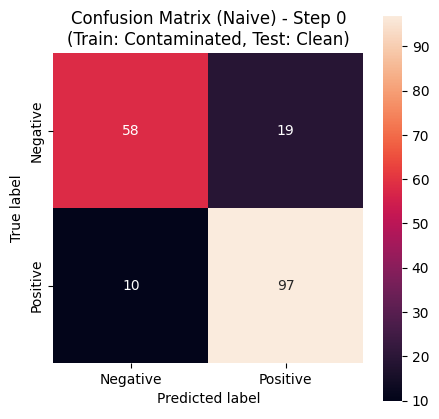


===== Training Neural Network (Naive) at Step 1 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 1 | Training time (Naive): 0.1298 sec
Step 1 | Training Accuracy (Naive): 0.8760
Misure di performance globali neural network naive

Accuracy: 0.8369565217391305
Precision: 0.8130081300813008
Recall: 0.9345794392523364
F1-score: 0.8695652173913043


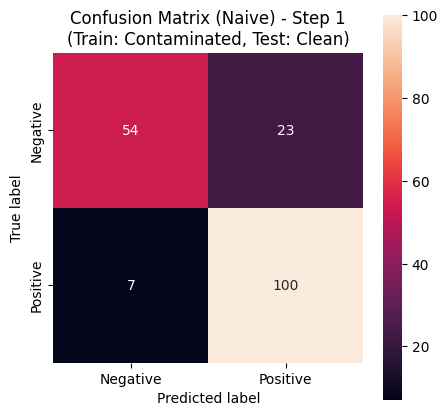


===== Training Neural Network (Naive) at Step 2 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 2 | Training time (Naive): 0.1280 sec
Step 2 | Training Accuracy (Naive): 0.8815
Misure di performance globali neural network naive

Accuracy: 0.8369565217391305
Precision: 0.8181818181818182
Recall: 0.9252336448598131
F1-score: 0.868421052631579


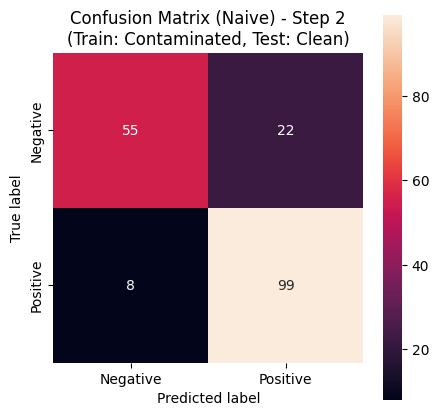


===== Training Neural Network (Naive) at Step 3 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 3 | Training time (Naive): 0.0952 sec
Step 3 | Training Accuracy (Naive): 0.8815
Misure di performance globali neural network naive

Accuracy: 0.8260869565217391
Precision: 0.8260869565217391
Recall: 0.8878504672897196
F1-score: 0.8558558558558559


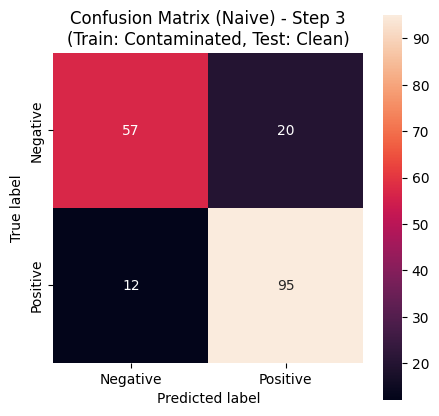


===== Training Neural Network (Naive) at Step 4 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 4 | Training time (Naive): 0.1250 sec
Step 4 | Training Accuracy (Naive): 0.8828
Misure di performance globali neural network naive

Accuracy: 0.842391304347826
Precision: 0.819672131147541
Recall: 0.9345794392523364
F1-score: 0.8733624454148472


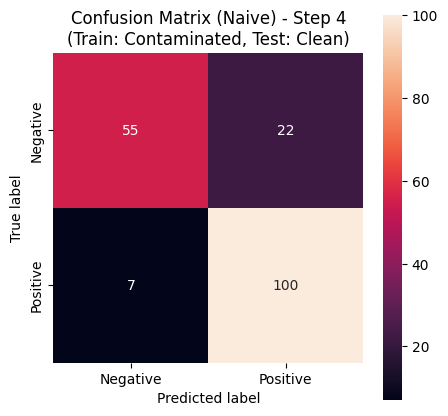


===== Training Neural Network (Naive) at Step 5 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 5 | Training time (Naive): 0.1252 sec
Step 5 | Training Accuracy (Naive): 0.8883
Misure di performance globali neural network naive

Accuracy: 0.8206521739130435
Precision: 0.8189655172413793
Recall: 0.8878504672897196
F1-score: 0.852017937219731


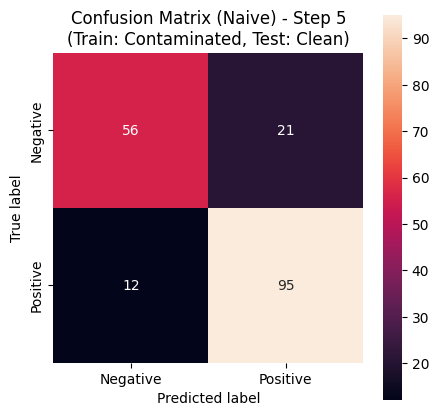


===== Training Neural Network (Naive) at Step 6 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 6 | Training time (Naive): 0.1263 sec
Step 6 | Training Accuracy (Naive): 0.8869
Misure di performance globali neural network naive

Accuracy: 0.8206521739130435
Precision: 0.8083333333333333
Recall: 0.9065420560747663
F1-score: 0.8546255506607929


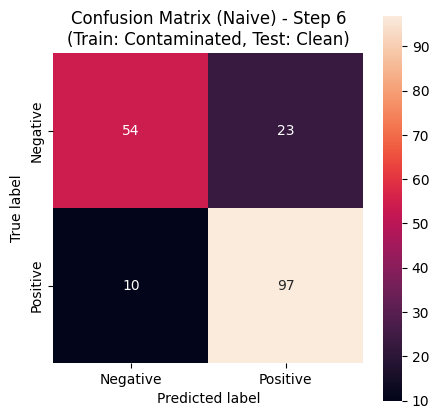


===== Training Neural Network (Naive) at Step 7 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 7 | Training time (Naive): 0.1628 sec
Step 7 | Training Accuracy (Naive): 0.8665
Misure di performance globali neural network naive

Accuracy: 0.7717391304347826
Precision: 0.8651685393258427
Recall: 0.719626168224299
F1-score: 0.7857142857142857


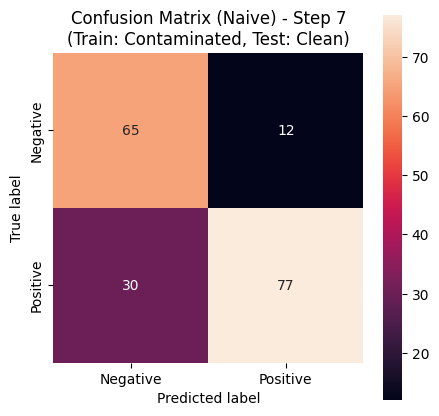


===== Training Neural Network (Naive) at Step 8 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 8 | Training time (Naive): 0.1609 sec
Step 8 | Training Accuracy (Naive): 0.8583
Misure di performance globali neural network naive

Accuracy: 0.7771739130434783
Precision: 0.8666666666666667
Recall: 0.7289719626168224
F1-score: 0.7918781725888325


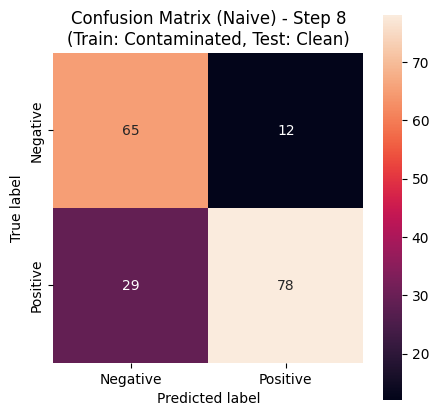


===== Training Neural Network (Naive) at Step 9 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 9 | Training time (Naive): 0.1665 sec
Step 9 | Training Accuracy (Naive): 0.8965
Misure di performance globali neural network naive

Accuracy: 0.8260869565217391
Precision: 0.8378378378378378
Recall: 0.8691588785046729
F1-score: 0.8532110091743119


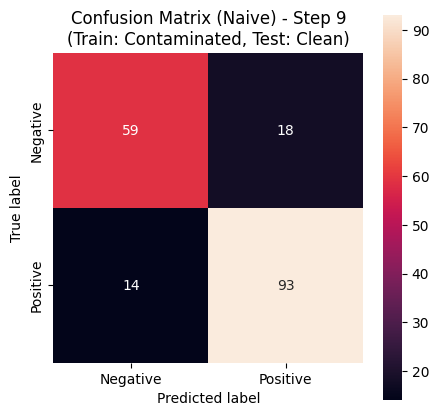


===== Training Neural Network (Naive) at Step 10 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 10 | Training time (Naive): 0.1044 sec
Step 10 | Training Accuracy (Naive): 0.8801
Misure di performance globali neural network naive

Accuracy: 0.7771739130434783
Precision: 0.83
Recall: 0.7757009345794392
F1-score: 0.8019323671497585


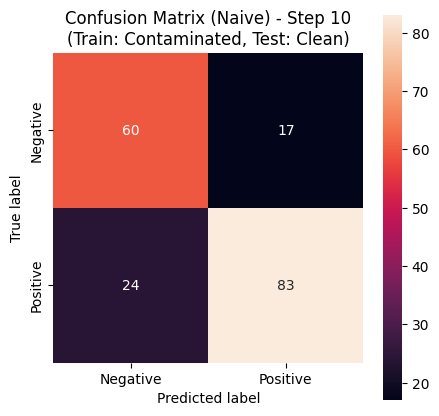



NEURAL NETWORK - OPTIMIZED


===== Training Neural Network (Optimized) at Step 0 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Step 0 | Training time (Optimized): 0.1180 sec
Step 0 | Training Accuracy (Optimized): 0.8747
Misure di performance globali neural network optimized

Accuracy: 0.842391304347826
Precision: 0.8362068965517241
Recall: 0.9065420560747663
F1-score: 0.8699551569506726


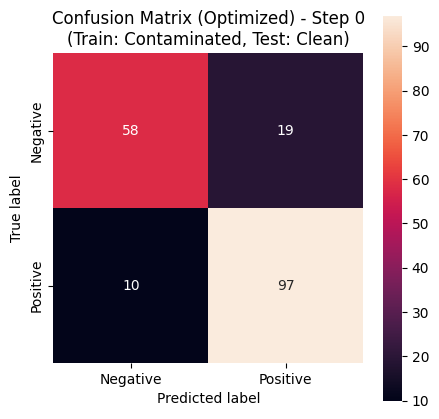


===== Training Neural Network (Optimized) at Step 1 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 1 | Training time (Optimized): 0.1369 sec
Step 1 | Training Accuracy (Optimized): 0.8760
Misure di performance globali neural network optimized

Accuracy: 0.8369565217391305
Precision: 0.8130081300813008
Recall: 0.9345794392523364
F1-score: 0.8695652173913043


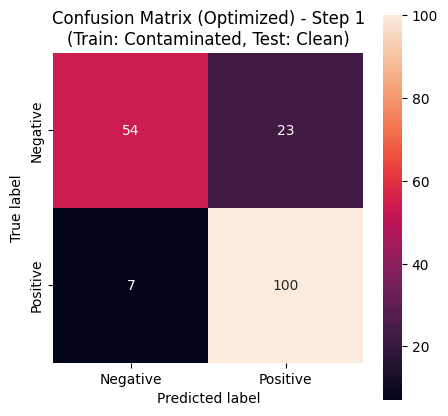


===== Training Neural Network (Optimized) at Step 2 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 2 | Training time (Optimized): 0.1252 sec
Step 2 | Training Accuracy (Optimized): 0.8815
Misure di performance globali neural network optimized

Accuracy: 0.8369565217391305
Precision: 0.8181818181818182
Recall: 0.9252336448598131
F1-score: 0.868421052631579


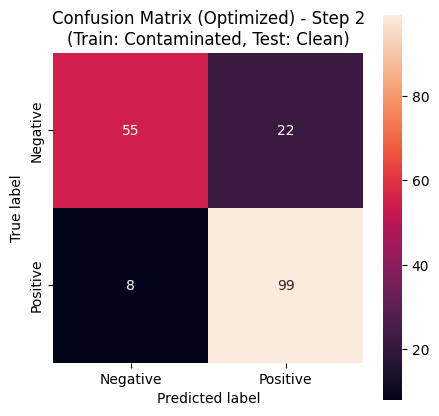


===== Training Neural Network (Optimized) at Step 3 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 3 | Training time (Optimized): 0.1897 sec
Step 3 | Training Accuracy (Optimized): 0.8815
Misure di performance globali neural network optimized

Accuracy: 0.8260869565217391
Precision: 0.8260869565217391
Recall: 0.8878504672897196
F1-score: 0.8558558558558559


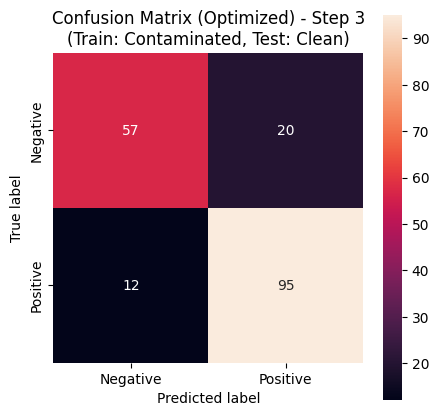


===== Training Neural Network (Optimized) at Step 4 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 4 | Training time (Optimized): 0.1308 sec
Step 4 | Training Accuracy (Optimized): 0.8828
Misure di performance globali neural network optimized

Accuracy: 0.842391304347826
Precision: 0.819672131147541
Recall: 0.9345794392523364
F1-score: 0.8733624454148472


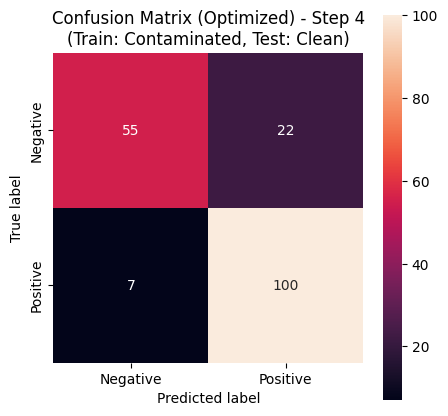


===== Training Neural Network (Optimized) at Step 5 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 5 | Training time (Optimized): 0.0923 sec
Step 5 | Training Accuracy (Optimized): 0.8883
Misure di performance globali neural network optimized

Accuracy: 0.8206521739130435
Precision: 0.8189655172413793
Recall: 0.8878504672897196
F1-score: 0.852017937219731


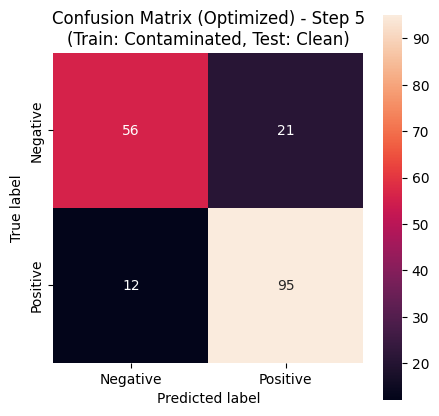


===== Training Neural Network (Optimized) at Step 6 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 6 | Training time (Optimized): 0.1328 sec
Step 6 | Training Accuracy (Optimized): 0.8869
Misure di performance globali neural network optimized

Accuracy: 0.8206521739130435
Precision: 0.8083333333333333
Recall: 0.9065420560747663
F1-score: 0.8546255506607929


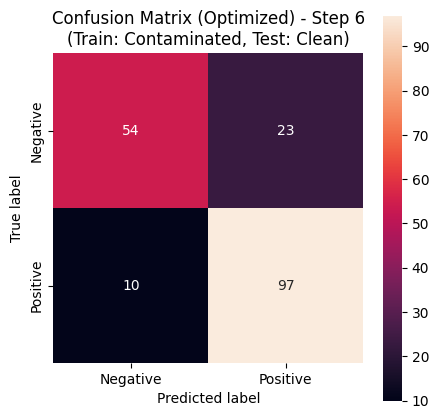


===== Training Neural Network (Optimized) at Step 7 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 7 | Training time (Optimized): 0.1601 sec
Step 7 | Training Accuracy (Optimized): 0.8665
Misure di performance globali neural network optimized

Accuracy: 0.7717391304347826
Precision: 0.8651685393258427
Recall: 0.719626168224299
F1-score: 0.7857142857142857


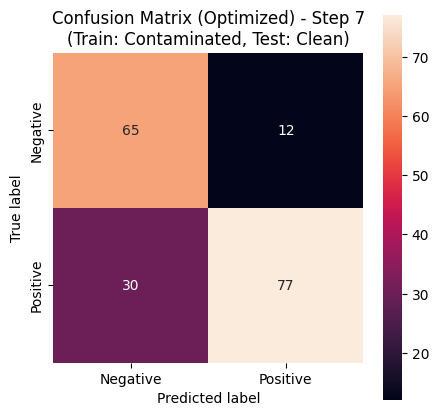


===== Training Neural Network (Optimized) at Step 8 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 8 | Training time (Optimized): 0.2056 sec
Step 8 | Training Accuracy (Optimized): 0.8583
Misure di performance globali neural network optimized

Accuracy: 0.7771739130434783
Precision: 0.8666666666666667
Recall: 0.7289719626168224
F1-score: 0.7918781725888325


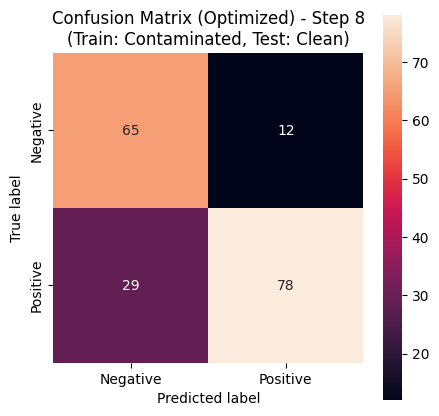


===== Training Neural Network (Optimized) at Step 9 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 9 | Training time (Optimized): 0.1382 sec
Step 9 | Training Accuracy (Optimized): 0.8965
Misure di performance globali neural network optimized

Accuracy: 0.8260869565217391
Precision: 0.8378378378378378
Recall: 0.8691588785046729
F1-score: 0.8532110091743119


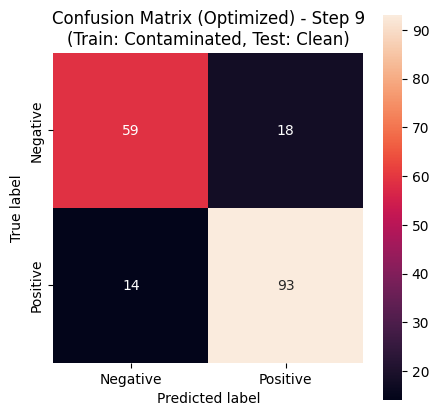


===== Training Neural Network (Optimized) at Step 10 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 10 | Training time (Optimized): 0.0947 sec
Step 10 | Training Accuracy (Optimized): 0.8801
Misure di performance globali neural network optimized

Accuracy: 0.7771739130434783
Precision: 0.83
Recall: 0.7757009345794392
F1-score: 0.8019323671497585


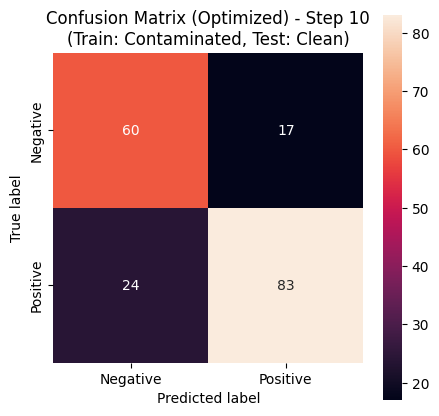

In [51]:
best_dt = best_dt = joblib.load('best_decision_tree_model.pkl')
best_svm = joblib.load('best_svm_model.pkl')
best_nn = joblib.load('best_nn_model.pkl')
best_nn_params = {
    'activation': best_nn.get('model__activation', 'relu'),
    'hidden_layer_sizes': best_nn.get('model__hidden_layer_sizes', (100,)),
    'random_state': 42,
    'max_iter': 1000
}

X_original = df.drop('HeartDisease', axis=1)  # df è il dataset originale pulito
y_original = df['HeartDisease']

# Split del dataset originale per ottenere il test set pulito
X_temp, X_test_clean, y_temp, y_test_clean = train_test_split(
    X_original, y_original, test_size=0.2, random_state=0
)



def train_and_evaluate_model(datasets, X_test_clean, y_test_clean, 
                             model_class, model_params, model_name, 
                             approach_name, timing_collector, 
                             all_metrics_list, generator=None,
                             optimized_params=None):
    """
    Funzione generica per addestrare e valutare modelli su dataset contaminati
    
    Parameters:
    -----------
    datasets : list
        Lista dei dataset contaminati per ogni step
    X_test_clean, y_test_clean : array-like
        Test set pulito (costante per tutti gli step)
    model_class : class
        Classe del modello (es. DecisionTreeClassifier, SVC, MLPClassifier)
    model_params : dict
        Parametri base del modello
    model_name : str
        Nome del modello per le metriche
    approach_name : str
        Nome dell'approccio (es. 'Naive', 'Optimized')
    timing_collector : dict
        Dizionario per raccogliere i tempi di training
    all_metrics_list : list
        Lista per raccogliere tutte le metriche
    generator : object, optional
        Generatore di outlier per contare campioni contaminati
    optimized_params : dict, optional
        Parametri ottimizzati (se diversi da model_params)
    """
    
    # Usa parametri ottimizzati se forniti, altrimenti usa quelli base
    final_params = optimized_params if optimized_params is not None else model_params
    
    print(f"\n\n======================")
    print(f"{model_name.upper()} - {approach_name.upper()}")
    print(f"======================\n")
    
    for step_idx, contaminated_df in enumerate(datasets):
        print(f"\n===== Training {model_name} ({approach_name}) at Step {step_idx} =====")
        
        # Prepara dati dal dataset contaminato per il TRAINING
        X_contaminated = contaminated_df.drop('HeartDisease', axis=1)
        y_contaminated = contaminated_df['HeartDisease']
        
        # Split del dataset contaminato SOLO per ottenere il training set
        X_train_contaminated, _, y_train_contaminated, _ = train_test_split(
            X_contaminated, y_contaminated, test_size=0.2, random_state=0
        )
        
        # Training su dati contaminati, test su dati puliti
        X_train = X_train_contaminated
        y_train = y_train_contaminated
        X_test = X_test_clean
        y_test = y_test_clean
        
        print(f"Training set size: {len(X_train)} samples (contaminated)")
        print(f"Test set size: {len(X_test)} samples (clean)")
        
        # Conta campioni contaminati nel training set (solo se disponibile)
        if step_idx > 0 and generator is not None:
            contaminated_training_samples = len(set(X_train.index) & generator.outlier_indices)
            print(f"Contaminated samples in training set: {contaminated_training_samples}")
        
        # Crea e addestra il modello
        model = model_class(**final_params)
        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        
        training_time = end_time - start_time
        print(f"Step {step_idx} | Training time ({approach_name}): {training_time:.4f} sec")
        
        # Salva il tempo nel dizionario
        timing_key = f"{model_name.lower().replace(' ', '_')}_{approach_name.lower()}_training_step_{step_idx}"
        timing_collector[timing_key] = training_time
        
        # Accuracy sul training (contaminato)
        accuracy_train = model.score(X_train, y_train)
        print(f"Step {step_idx} | Training Accuracy ({approach_name}): {accuracy_train:.4f}")
        
        # Predizioni sul test set PULITO
        y_pred = model.predict(X_test)
        
        # Calcolo metriche
        metrics = calculate_metrics(y_test, y_pred, model_name, approach_name, step_idx)
        metrics['training_time'] = training_time
        metrics['train_accuracy'] = accuracy_train
        metrics['contamination_step'] = step_idx
        metrics['test_set_type'] = 'clean'
        
        # Aggiungi alle metriche globali
        all_metrics_list.append(metrics)
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5,5))
        sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        plt.title(f"Confusion Matrix ({approach_name}) - Step {step_idx}\n(Train: Contaminated, Test: Clean)")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

train_and_evaluate_model(datasets=datasets,
        X_test_clean=X_test_clean,
        y_test_clean=y_test_clean,
        model_class=DecisionTreeClassifier,
        model_params={},  # Usa i parametri di default
        model_name='Decision Tree',
        approach_name='Naive',
        timing_collector=timing_collector_outliers,
        all_metrics_list=all_metrics_outliers,
        generator=generator)

train_and_evaluate_model(datasets=datasets,
        X_test_clean=X_test_clean,
        y_test_clean=y_test_clean,
        model_class=DecisionTreeClassifier,
        model_params=best_dt, 
        model_name='Decision Tree',
        approach_name='Optimized',
        timing_collector=timing_collector_outliers,
        all_metrics_list=all_metrics_outliers,
        generator=generator)

train_and_evaluate_model(datasets=datasets,
        X_test_clean=X_test_clean,
        y_test_clean=y_test_clean,
        model_class=svm.SVC,
        model_params={},  # Usa i parametri di default
        model_name='SVM',
        approach_name='Naive',
        timing_collector=timing_collector_outliers,
        all_metrics_list=all_metrics_outliers,
        generator=generator)

train_and_evaluate_model(datasets=datasets,
        X_test_clean=X_test_clean,
        y_test_clean=y_test_clean,
        model_class=svm.SVC,
        model_params=best_svm, 
        model_name='SVM',
        approach_name='Optimized',
        timing_collector=timing_collector_outliers,
        all_metrics_list=all_metrics_outliers,
        generator=generator)

train_and_evaluate_model(datasets=datasets,
        X_test_clean=X_test_clean,
        y_test_clean=y_test_clean,
        model_class=MLPClassifier,
        model_params={'random_state': 42, 'max_iter': 1000}, 
        model_name='Neural Network',
        approach_name='Naive',
        timing_collector=timing_collector_outliers,
        all_metrics_list=all_metrics_outliers,
        generator=generator)

train_and_evaluate_model(datasets=datasets,
        X_test_clean=X_test_clean,
        y_test_clean=y_test_clean,
        model_class=MLPClassifier,
        model_params=best_nn_params,
        model_name='Neural Network',
        approach_name='Optimized',
        timing_collector=timing_collector_outliers,
        all_metrics_list=all_metrics_outliers,
        generator=generator)

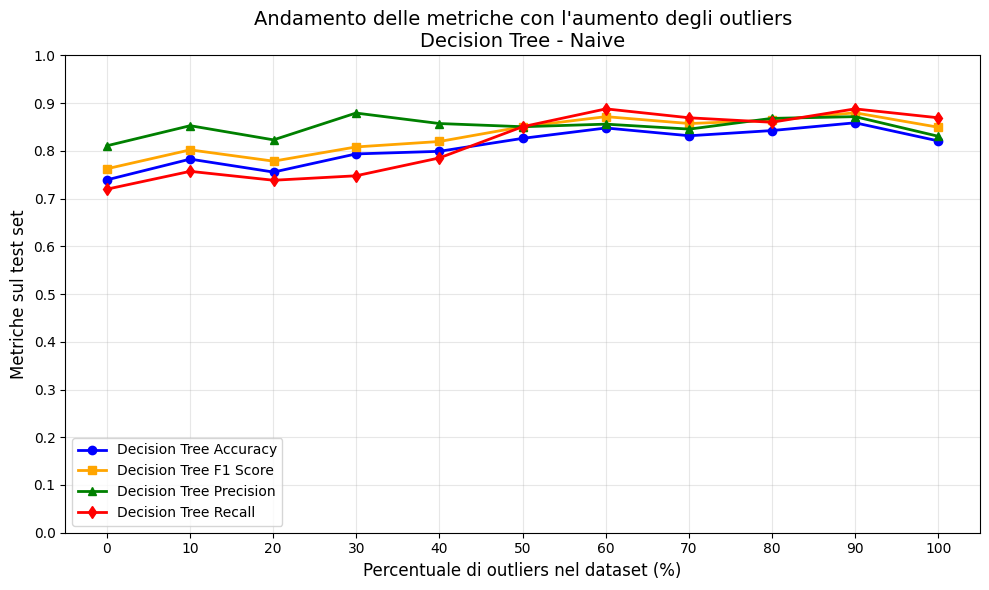

<Figure size 640x480 with 0 Axes>

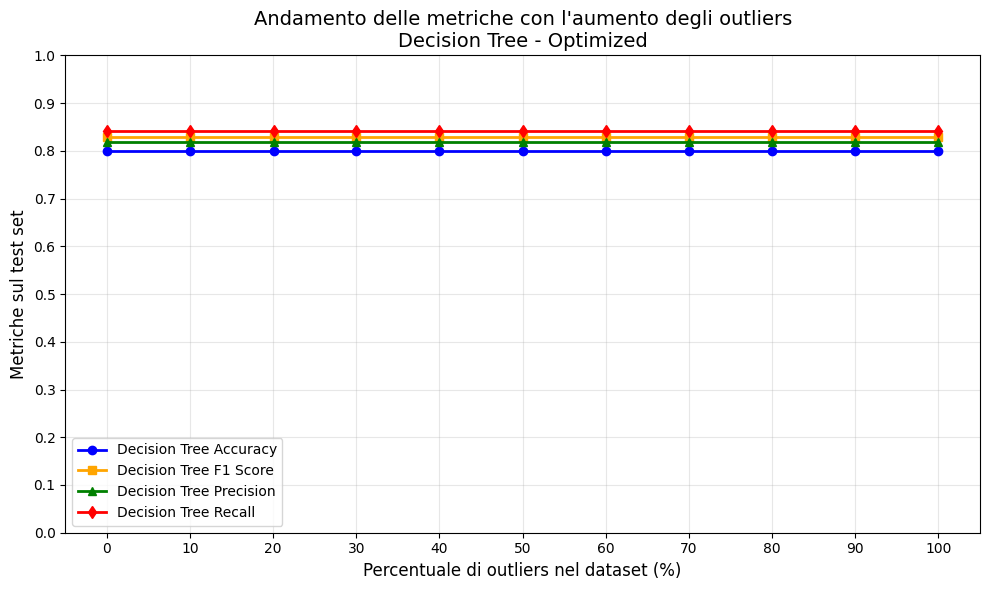

<Figure size 640x480 with 0 Axes>

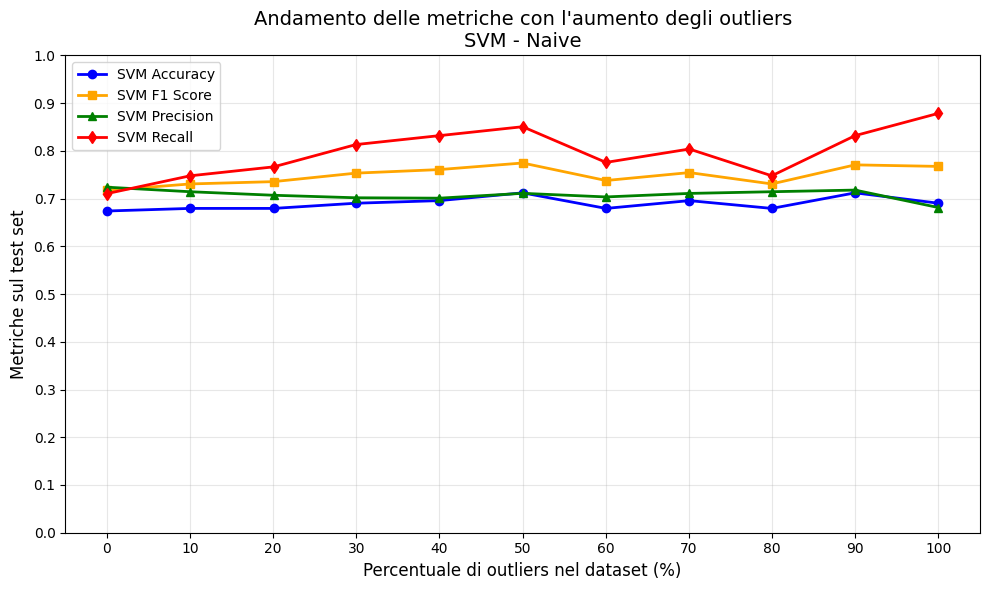

<Figure size 640x480 with 0 Axes>

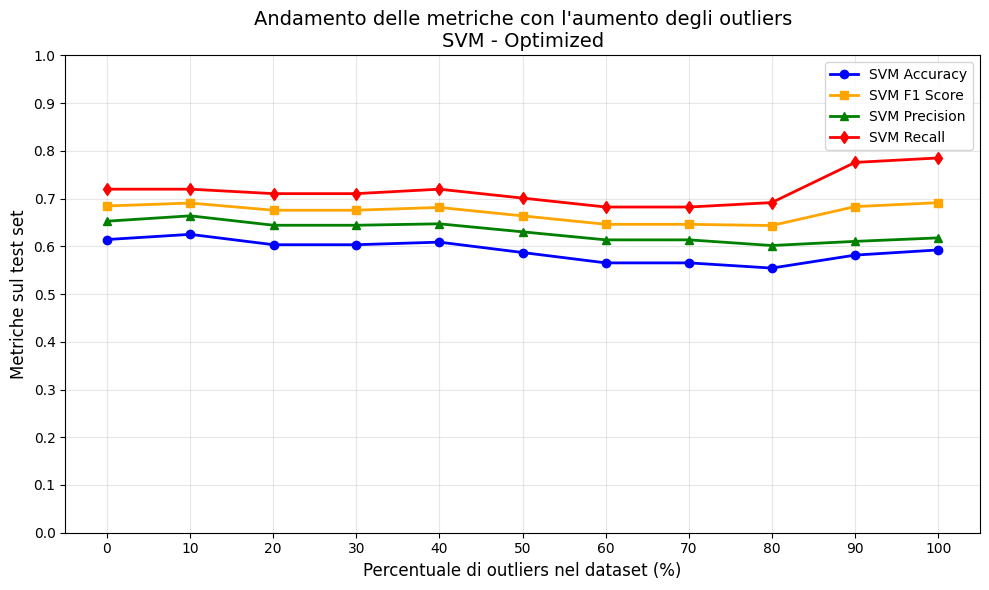

<Figure size 640x480 with 0 Axes>

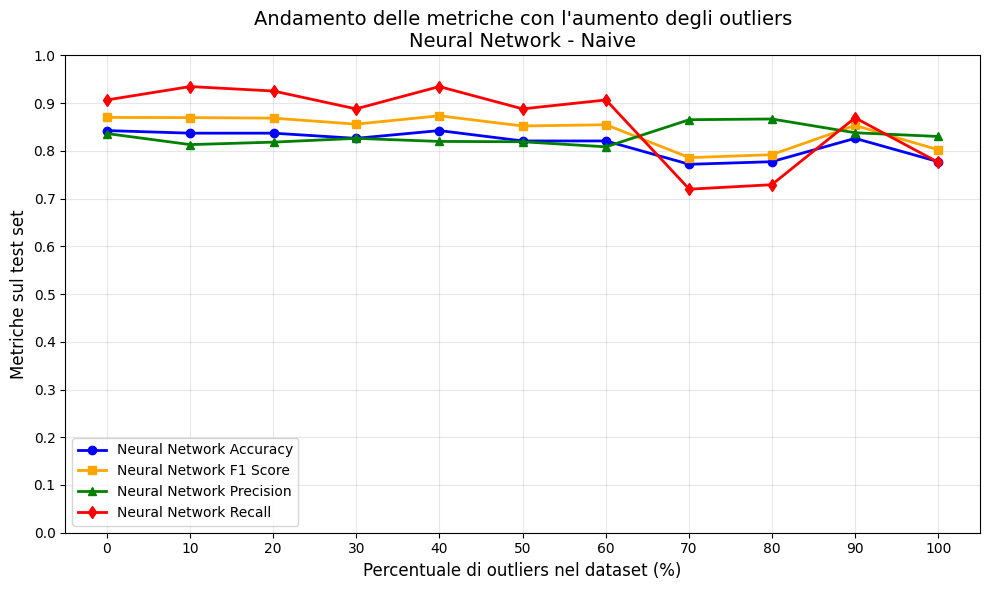

<Figure size 640x480 with 0 Axes>

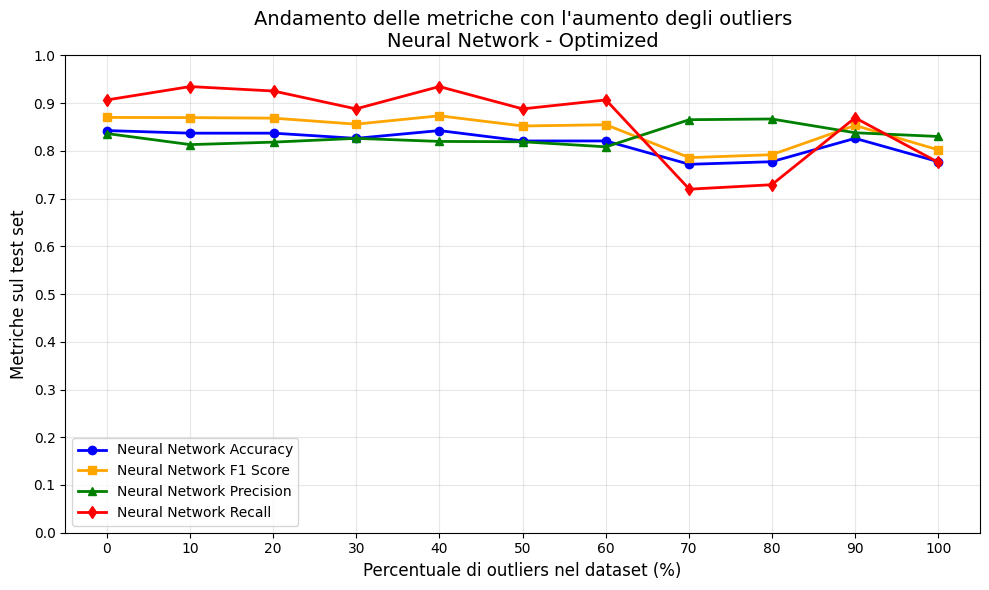

<Figure size 640x480 with 0 Axes>

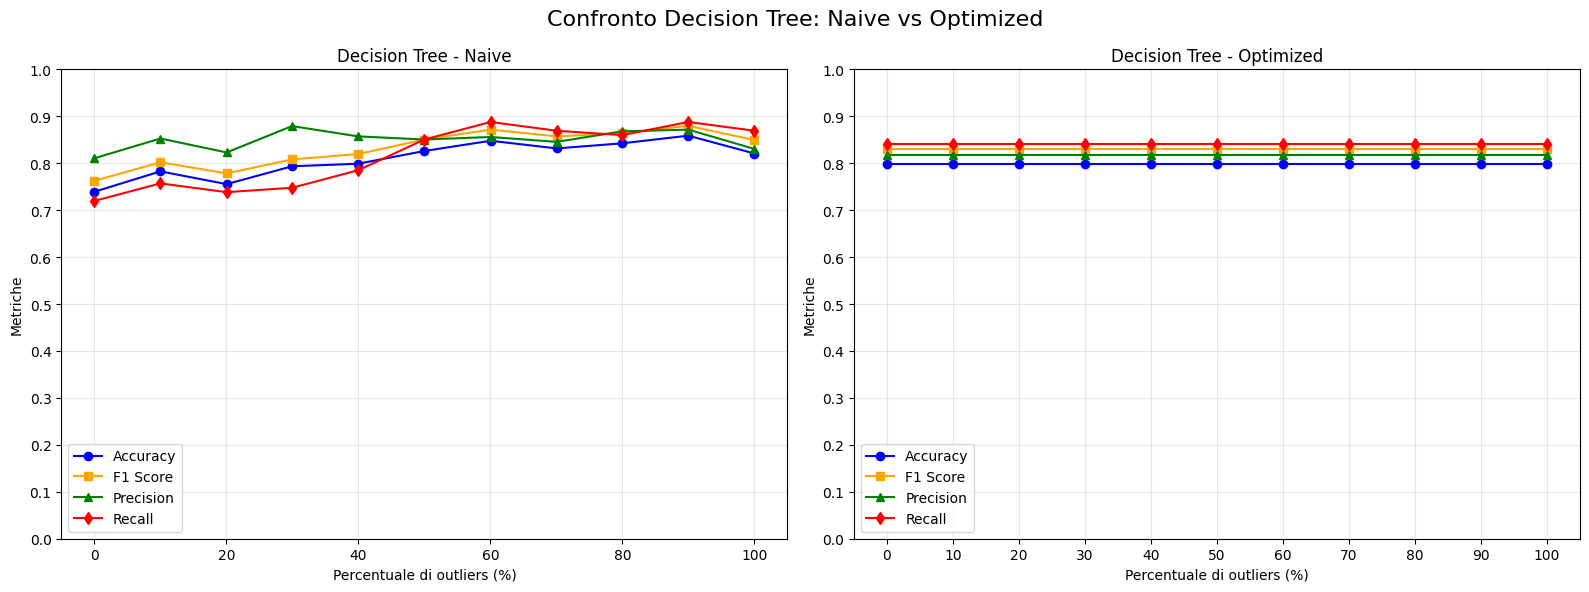

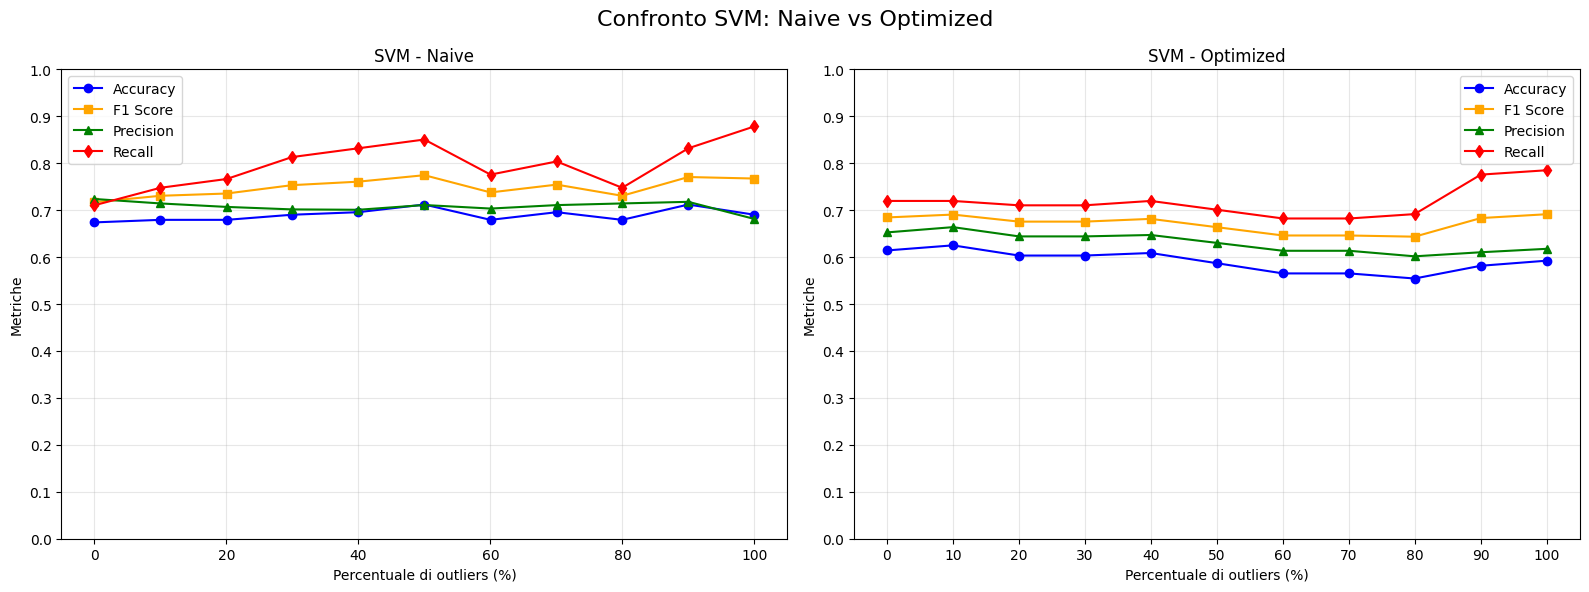

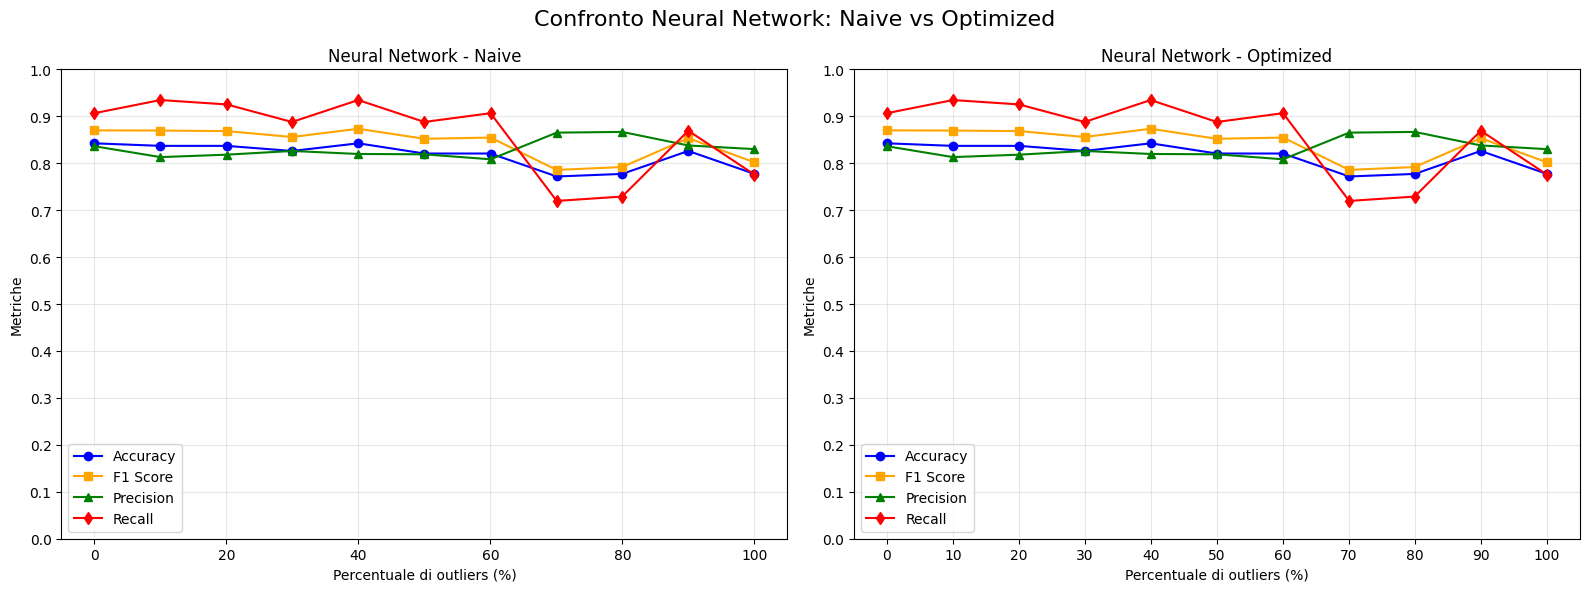

In [ ]:
def plot_model_metrics_vs_contamination(all_metrics_outliers, contamination_history, 
                                        model_name, approach='Optimized', 
                                        figsize=(10, 6), save_path=None):
    """
    Crea un grafico delle metriche vs percentuale di contaminazione per un modello specifico
    
    Parameters:
    -----------
    all_metrics_outliers : list
        Lista con tutte le metriche raccolte
    contamination_history : list
        Storia della contaminazione con step e actual_rate
    model_name : str
        Nome del modello da plottare (es. 'Decision Tree', 'SVM', 'Neural Network')
    approach : str, default 'Optimized'
        Approccio da visualizzare ('Naive' o 'Optimized')
    figsize : tuple, default (10, 6)
        Dimensione della figura
    save_path : str, optional
        Path per salvare il grafico (se None, non salva)
    
    Returns:
    --------
    plt.Figure : La figura matplotlib creata
    """
    
    # Creo DataFrame da contamination_history
    contam_df = pd.DataFrame([
        {"step": h['step'], "contamination_rate": h['actual_rate']}
        for h in contamination_history
    ])
    
    # Aggiungo il caso iniziale (0% outliers) se non presente
    if 0 not in contam_df["step"].values:
        contam_df = pd.concat([
            pd.DataFrame([{"step": 0, "contamination_rate": 0.0}]),
            contam_df
        ], ignore_index=True)
    
    # Creo DataFrame delle metriche
    metrics_df = pd.DataFrame(all_metrics_outliers)
    
    # Merge su 'step'
    merged_df = pd.merge(metrics_df, contam_df, on="step", how="left")
    
    # Ordino i valori per contamination_rate
    merged_df = merged_df.sort_values("contamination_rate")
    
    # Filtro per il modello e approccio specifici
    filtered_df = merged_df[
        (merged_df["approach"] == approach) & 
        (merged_df["model"] == model_name)
    ]
    
    # Verifica che ci siano dati da plottare
    if filtered_df.empty:
        print(f"Nessun dato trovato per {model_name} - {approach}")
        return None
    
    # Crea il grafico
    plt.figure(figsize=figsize)
    
    # Plot delle metriche
    plt.plot(filtered_df["contamination_rate"]*100, filtered_df["accuracy"], 
             marker='o', color='blue', linewidth=2, markersize=6, label=f"{model_name} Accuracy")
    plt.plot(filtered_df["contamination_rate"]*100, filtered_df["f1_score"], 
             marker='s', color='orange', linewidth=2, markersize=6, label=f"{model_name} F1 Score")
    plt.plot(filtered_df["contamination_rate"]*100, filtered_df["precision"], 
             marker='^', color='green', linewidth=2, markersize=6, label=f"{model_name} Precision")
    plt.plot(filtered_df["contamination_rate"]*100, filtered_df["recall"], 
             marker='d', color='red', linewidth=2, markersize=6, label=f"{model_name} Recall")
    
    # Configurazione del grafico
    plt.xlabel("Percentuale di outliers nel dataset (%)", fontsize=12)
    plt.ylabel("Metriche sul test set", fontsize=12)
    plt.title(f"Andamento delle metriche con l'aumento degli outliers\n{model_name} - {approach}", fontsize=14)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xticks(np.arange(0, max(filtered_df["contamination_rate"]*100) + 10, 10))
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # Migliora l'aspetto
    plt.tight_layout()
    
    plt.show()
    
    return plt.gcf()

plot_model_metrics_vs_contamination(
    all_metrics_outliers=all_metrics_outliers,
    contamination_history=contamination_history,
    model_name='Decision Tree',
    approach='Naive'
)

plot_model_metrics_vs_contamination(
    all_metrics_outliers=all_metrics_outliers,
    contamination_history=contamination_history,
    model_name='Decision Tree',
    approach='Optimized'
)

plot_model_metrics_vs_contamination(
    all_metrics_outliers=all_metrics_outliers,
    contamination_history=contamination_history,
    model_name='SVM',
    approach='Naive'
)

plot_model_metrics_vs_contamination(
    all_metrics_outliers=all_metrics_outliers,
    contamination_history=contamination_history,
    model_name='SVM',
    approach='Optimized'
)

plot_model_metrics_vs_contamination(
    all_metrics_outliers=all_metrics_outliers,
    contamination_history=contamination_history,
    model_name='Neural Network',
    approach='Naive'
)

plot_model_metrics_vs_contamination(
    all_metrics_outliers=all_metrics_outliers,
    contamination_history=contamination_history,
    model_name='Neural Network',
    approach='Optimized'
)

# 3. Confronto Naive vs Optimized per un modello
def plot_naive_vs_optimized(model_name):
    """Confronta approccio Naive vs Optimized per un modello"""
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    for i, approach in enumerate(['Naive', 'Optimized']):
        # Prepara dati
        contam_df = pd.DataFrame([
            {"step": h['step'], "contamination_rate": h['actual_rate']}
            for h in contamination_history
        ])
        
        if 0 not in contam_df["step"].values:
            contam_df = pd.concat([
                pd.DataFrame([{"step": 0, "contamination_rate": 0.0}]),
                contam_df
            ], ignore_index=True)
        
        metrics_df = pd.DataFrame(all_metrics_outliers)
        merged_df = pd.merge(metrics_df, contam_df, on="step", how="left")
        merged_df = merged_df.sort_values("contamination_rate")
        
        filtered_df = merged_df[
            (merged_df["approach"] == approach) & 
            (merged_df["model"] == model_name)
        ]
        
        # Plot su subplot
        axes[i].plot(filtered_df["contamination_rate"]*100, filtered_df["accuracy"], 
                    marker='o', color='blue', label="Accuracy")
        axes[i].plot(filtered_df["contamination_rate"]*100, filtered_df["f1_score"], 
                    marker='s', color='orange', label="F1 Score")
        axes[i].plot(filtered_df["contamination_rate"]*100, filtered_df["precision"], 
                    marker='^', color='green', label="Precision")
        axes[i].plot(filtered_df["contamination_rate"]*100, filtered_df["recall"], 
                    marker='d', color='red', label="Recall")
        
        axes[i].set_xlabel("Percentuale di outliers (%)")
        axes[i].set_ylabel("Metriche")
        axes[i].set_title(f"{model_name} - {approach}")
        axes[i].set_yticks(np.arange(0, 1.1, 0.1))
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
    
    plt.suptitle(f"Confronto {model_name}: Naive vs Optimized", fontsize=16)
    plt.xticks(np.arange(0,110,10))
    plt.tight_layout()
    plt.show()


plot_naive_vs_optimized('Decision Tree')
plot_naive_vs_optimized('SVM')
plot_naive_vs_optimized('Neural Network')